In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from dateutil.easter import easter
from datetime import timedelta
import lightgbm as lgb
import optuna
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
import seaborn as sns
import re

warnings.filterwarnings("ignore")

In [2]:
# Loading Train and Test data, setting index as datetime

data = pd.read_parquet(Path("data") / "train.parquet")


test_data = pd.read_parquet(Path("data") / "test.parquet")


data["date"] = pd.to_datetime(data["date"])


data = data.set_index("date")


test_data["date"] = pd.to_datetime(test_data["date"])


test_data = test_data.set_index("date")

In [3]:
# Class for adding French holidays
class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        Holiday("Labour Day", month=5, day=1),
        Holiday("Victory in Europe Day", month=5, day=8),
        Holiday("Bastille Day", month=7, day=14),
        Holiday("Assumption of Mary", month=8, day=15),
        Holiday("All Saints' Day", month=11, day=1),
        Holiday("Armistice Day", month=11, day=11),
        Holiday("Christmas Day", month=12, day=25),
    ]

    @staticmethod
    def easter_related_holidays(year):
        easter_sunday = easter(year)
        return [
            (easter_sunday + timedelta(days=1), "Easter Monday"),
            (easter_sunday + timedelta(days=39), "Ascension Day"),
        ]

In [4]:
# Function to add cyclical features of hour and day
def cyclical_encode(df, column, max_value):
    df[column + "_sin"] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + "_cos"] = np.cos(2 * np.pi * df[column] / max_value)
    return df

In [5]:
# Function to create timeseries features
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear

    # Boolean for weekends
    df["is_weekend"] = df["dayofweek"].isin([5, 6])

    # cyclical
    df = cyclical_encode(df, "hour", 24)
    df = cyclical_encode(df, "dayofweek", 7)

    # Boolean for holidays
    cal = FrenchHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    easter_holidays = []

    for year in range(df.index.year.min(), df.index.year.max() + 1):
        for date, _ in FrenchHolidayCalendar.easter_related_holidays(year):
            easter_holidays.append(date)

    holidays = holidays.union(pd.to_datetime(easter_holidays))

    df["is_holiday"] = df.index.isin(holidays)

    # Lockdown periods
    lockdowns = {
        "lockdown_1": ("2020-03-17", "2020-05-10"),
        "lockdown_2": ("2020-10-28", "2020-12-01"),
        # with curfew from 7 PM to 6 AM
        "lockdown_3_1": ("2021-04-03 19:00:00", "2021-05-18 06:00:00"),
        # with curfew from 9 PM to 6 AM
        "lockdown_3_2": ("2021-05-19 21:00:00", "2021-06-08 06:00:00"),
        # with curfew from 11 PM to 6 AM
        "lockdown_3_3": ("2021-06-09 23:00:00", "2021-06-29 06:00:00"),
    }

    for lockdown, (start_date, end_date) in lockdowns.items():
        mask = (df.index >= start_date) & (df.index <= end_date)
        df[lockdown] = mask
    return df

In [6]:
# Selecting our basic features
train = data[["counter_name", "log_bike_count"]]
test = test_data[["counter_name", "log_bike_count"]]

In [7]:
# Applying our create features function
train = create_features(train)
test = create_features(test)

In [8]:
train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3
date,,,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000,2,1,3,9,245,False,0.500000,8.660254e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147,3,1,3,9,245,False,0.707107,7.071068e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000,4,1,3,9,245,False,0.866025,5.000000e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438,15,1,3,9,245,False,-0.707107,-7.071068e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585,18,1,3,9,245,False,-1.000000,-1.836970e-16,0.781831,0.62349,False,False,False,False,False,False


In [9]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [11]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [12]:
# initial XGBoost trial with OneHotEncoded categorical features
reg = xgb.XGBRegressor(n_estimators=1000)
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(
        handle_unknown="ignore"), cat_feature)],
    remainder="passthrough",
)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", reg)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metri...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [13]:
y_hat_xgb = pipeline.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train with basic features:", rmse_xgb_train)

y_pred_xgb = pipeline.predict(X_test)


rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)


print("XGB Test with basic features:", rmse_xgb_test)

XGB Train with basic features: 0.29752686796489825
XGB Test with basic features: 0.4082577358118286


In [14]:
xgb_model = pipeline.named_steps["model"]

xgb_model.feature_importances_

array([0.00892186, 0.00702595, 0.00920987, 0.00213758, 0.01642091,
       0.01013404, 0.0024176 , 0.00725503, 0.00660832, 0.03370572,
       0.0817513 , 0.00108996, 0.009926  , 0.00046998, 0.01181671,
       0.01308049, 0.00129746, 0.0025763 , 0.00214087, 0.00406736,
       0.04039664, 0.00420286, 0.0060809 , 0.00172708, 0.00411874,
       0.00057908, 0.00310336, 0.0018176 , 0.01565585, 0.04952789,
       0.04956602, 0.01309337, 0.02064273, 0.00192229, 0.00773416,
       0.02155171, 0.00605652, 0.00392166, 0.00497759, 0.00148916,
       0.00504165, 0.00754669, 0.00666246, 0.0126468 , 0.00868246,
       0.00210475, 0.0253007 , 0.05912828, 0.0848714 , 0.06956862,
       0.00366187, 0.01664285, 0.00063871, 0.01371857, 0.00466891,
       0.00227814, 0.00411023, 0.00494048, 0.00077353, 0.00394886,
       0.00604228, 0.        , 0.01406753, 0.14538382, 0.00069285,
       0.00050762, 0.00030886, 0.        , 0.0014259 , 0.00180035,
       0.00145571, 0.00116057], dtype=float32)

In [15]:
# converting boolean to int so that XGBoost's 'hist' tree method can use them with no problems
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)

for column in boolean_columns:
    test[column] = test[column].astype(int)

In [16]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [17]:
# XGBoost without OneHot encoding
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

In [18]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521
[10]	validation_0-rmse:0.57309	validation_1-rmse:0.53558
[20]	validation_0-rmse:0.47970	validation_1-rmse:0.45625
[30]	validation_0-rmse:0.44736	validation_1-rmse:0.45121
[40]	validation_0-rmse:0.42716	validation_1-rmse:0.44005
[50]	validation_0-rmse:0.41277	validation_1-rmse:0.43328
[60]	validation_0-rmse:0.40376	validation_1-rmse:0.43189
[70]	validation_0-rmse:0.39551	validation_1-rmse:0.42840
[79]	validation_0-rmse:0.38829	validation_1-rmse:0.43065


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.39628110010541767
XGB Test: 0.42839758662117466


<Axes: title={'center': 'Feature Importances'}>

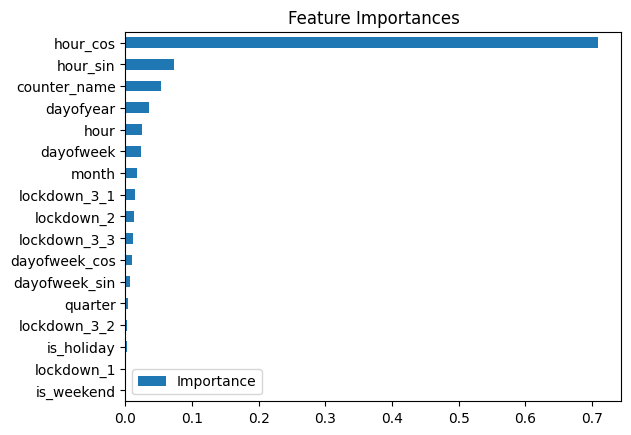

In [20]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [21]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.708811
hour_sin,0.072453
counter_name,0.053806
dayofyear,0.035033
hour,0.025501
dayofweek,0.023742
month,0.018035
lockdown_3_1,0.013969
lockdown_2,0.013313
lockdown_3_3,0.011502


In [22]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [23]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [24]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521
[10]	validation_0-rmse:0.57150	validation_1-rmse:0.53628
[20]	validation_0-rmse:0.48407	validation_1-rmse:0.46049
[30]	validation_0-rmse:0.45047	validation_1-rmse:0.44668
[40]	validation_0-rmse:0.42652	validation_1-rmse:0.43823
[50]	validation_0-rmse:0.41184	validation_1-rmse:0.43205
[60]	validation_0-rmse:0.40074	validation_1-rmse:0.42680
[70]	validation_0-rmse:0.39359	validation_1-rmse:0.42649
[80]	validation_0-rmse:0.38701	validation_1-rmse:0.42504
[90]	validation_0-rmse:0.38036	validation_1-rmse:0.42585
[99]	validation_0-rmse:0.37549	validation_1-rmse:0.42609


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [25]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.3817870566449684
XGB Test: 0.4233758908637934


<Axes: title={'center': 'Feature Importances'}>

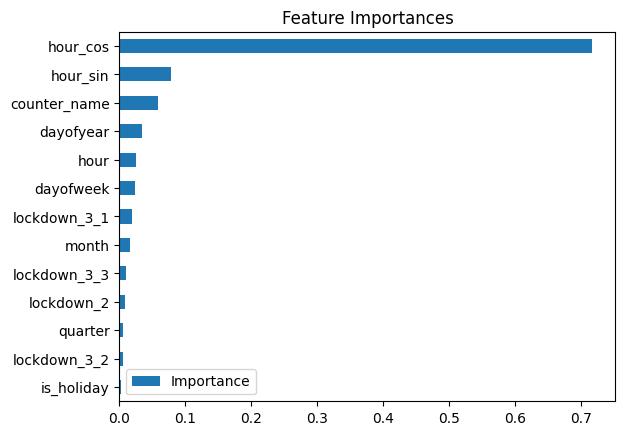

In [26]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [27]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.716523
hour_sin,0.078339
counter_name,0.057709
dayofyear,0.034547
hour,0.024535
dayofweek,0.023336
lockdown_3_1,0.018654
month,0.015414
lockdown_3_3,0.009458
lockdown_2,0.008548


In [28]:
# Trying catboost
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)

In [29]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5240483	test: 1.5238900	test1: 1.3446539	best: 1.3446539 (0)	total: 287ms	remaining: 4m 46s
10:	learn: 0.8718688	test: 0.8695631	test1: 0.7449179	best: 0.7449179 (10)	total: 1.15s	remaining: 1m 43s
20:	learn: 0.7551270	test: 0.7518565	test1: 0.6449331	best: 0.6449331 (20)	total: 2.01s	remaining: 1m 33s
30:	learn: 0.7099505	test: 0.7069519	test1: 0.6119519	best: 0.6119519 (30)	total: 2.98s	remaining: 1m 33s
40:	learn: 0.6869682	test: 0.6838987	test1: 0.5953858	best: 0.5953858 (40)	total: 4.05s	remaining: 1m 34s
50:	learn: 0.6702272	test: 0.6671027	test1: 0.5762580	best: 0.5762580 (50)	total: 5.1s	remaining: 1m 34s
60:	learn: 0.6469271	test: 0.6436659	test1: 0.5624391	best: 0.5624391 (60)	total: 6.09s	remaining: 1m 33s
70:	learn: 0.6273186	test: 0.6237231	test1: 0.5537703	best: 0.5537703 (70)	total: 7.03s	remaining: 1m 32s
80:	learn: 0.6158488	test: 0.6117575	test1: 0.5470219	best: 0.5470219 (80)	total: 7.99s	remaining: 1m 30s
90:	learn: 0.603209

In [30]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.4406423273301501
CAT Test: 0.422703193361417


<Axes: title={'center': 'Feature Importances'}>

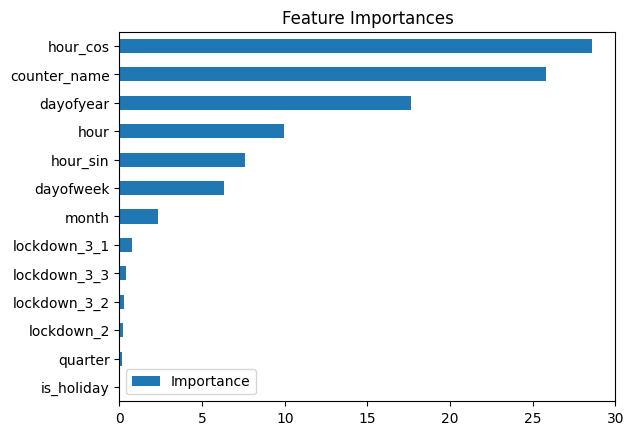

In [31]:
fi = pd.DataFrame(
    data=cat_reg.feature_importances_,
    index=features,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

# Updated Weather

In [10]:
weather_data = pd.read_csv("data/external_data_cleaned_updated.csv")

In [11]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.set_index("date", inplace=True)

In [12]:
weather_data.head()

,pmer,tend,cod_tend,dd,ff,t,td,u,vv,ww,...,etat_sol_lag6h,etat_sol_lag9h,etat_sol_lag12h,etat_sol_lag24h,etat_sol_lag168h,rr12_lag6h,rr12_lag9h,rr12_lag12h,rr12_lag24h,rr12_lag168h
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 02:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 03:00:00,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 04:00:00,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9973 entries, 2020-09-01 00:00:00 to 2021-10-21 12:00:00
Data columns (total 74 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pmer                       9973 non-null   int64  
 1   tend                       9973 non-null   int64  
 2   cod_tend                   9973 non-null   int64  
 3   dd                         9973 non-null   int64  
 4   ff                         9973 non-null   float64
 5   t                          9973 non-null   float64
 6   td                         9973 non-null   float64
 7   u                          9973 non-null   int64  
 8   vv                         9973 non-null   int64  
 9   ww                         9973 non-null   int64  
 10  w1                         9973 non-null   float64
 11  w2                         9973 non-null   float64
 12  n                          9973 non-null   float64
 13  nbas        

In [14]:
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)


for column in boolean_columns:
    test[column] = test[column].astype(int)

In [15]:
combined_train = train.merge(
    weather_data, left_index=True, right_index=True, how="left"
)
combined_test = test.merge(
    weather_data, left_index=True, right_index=True, how="left")

In [16]:
combined_train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'is_holiday', 'lockdown_1',
       'lockdown_2', 'lockdown_3_1', 'lockdown_3_2', 'lockdown_3_3', 'pmer',
       'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2',
       'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tend24', 'raf10',
       'rafper', 'etat_sol', 'ht_neige', 'ssfrai', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24', 'nnuage1', 'ctype1', 'hnuage1', 'temp_humidity_interaction',
       't_lag6h', 't_lag9h', 't_lag12h', 't_lag24h', 't_lag168h', 'td_lag6h',
       'td_lag9h', 'td_lag12h', 'td_lag24h', 'td_lag168h', 'u_lag6h',
       'u_lag9h', 'u_lag12h', 'u_lag24h', 'u_lag168h', 'ww_lag6h', 'ww_lag9h',
       'ww_lag12h', 'ww_lag24h', 'ww_lag168h', 'n_lag6h', 'n_lag9h',
       'n_lag12h', 'n_lag24h', 'n_lag168h', 'tend24_lag6h', 'tend24_lag9h',
       'tend24_lag12h', 'tend24_la

In [83]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag12h",
    "t_lag24h",
    "t_lag168h",
    "td_lag6h",
    "td_lag9h",
    "td_lag12h",
    "td_lag24h",
    "td_lag168h",
    "u_lag6h",
    "u_lag9h",
    "u_lag12h",
    "u_lag24h",
    "u_lag168h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag12h",
    "ww_lag24h",
    "ww_lag168h",
    "n_lag6h",
    "n_lag9h",
    "n_lag12h",
    "n_lag24h",
    "n_lag168h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag12h",
    "tend24_lag24h",
    "tend24_lag168h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag12h",
    "etat_sol_lag24h",
    "etat_sol_lag168h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag12h",
    "rr12_lag24h",
    "rr12_lag168h",
]


target = ["log_bike_count"]


cat_feature = ["counter_name"]

In [84]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [85]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

In [86]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21203	validation_1-rmse:2.34764
[10]	validation_0-rmse:0.57357	validation_1-rmse:0.54235
[20]	validation_0-rmse:0.49002	validation_1-rmse:0.51054
[30]	validation_0-rmse:0.45830	validation_1-rmse:0.47399
[40]	validation_0-rmse:0.43830	validation_1-rmse:0.46838
[50]	validation_0-rmse:0.42236	validation_1-rmse:0.45597
[60]	validation_0-rmse:0.41289	validation_1-rmse:0.45310
[70]	validation_0-rmse:0.40543	validation_1-rmse:0.45309


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [87]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.4122953660695877
XGB Test: 0.45257183500623505


<Axes: title={'center': 'Feature Importances XGBoost'}>

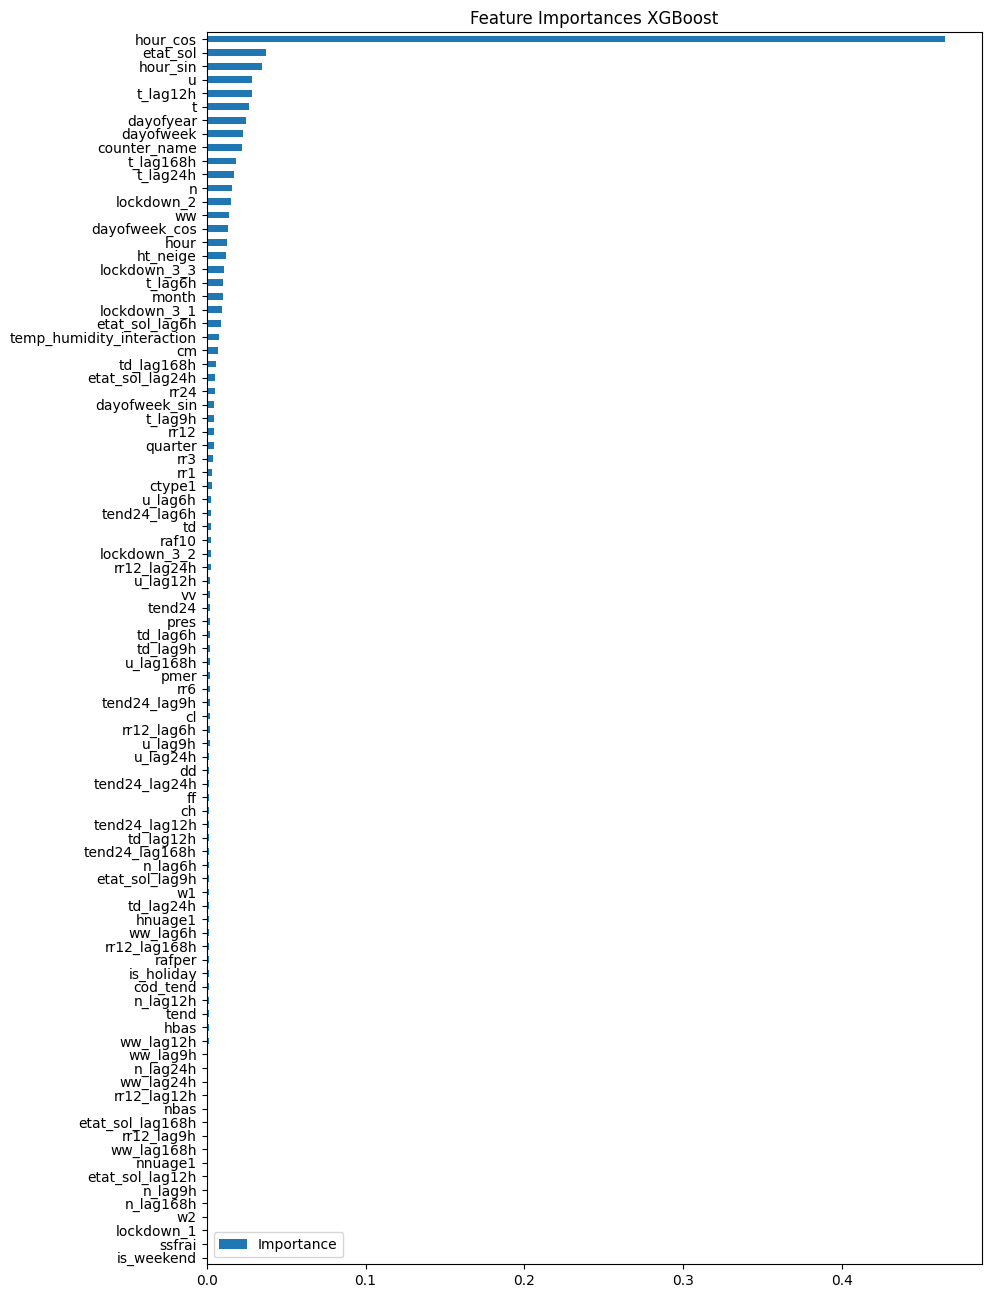

In [88]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [89]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.464699
etat_sol,0.037293
hour_sin,0.034944
u,0.028449
t_lag12h,0.028281
...,...
n_lag168h,0.000598
w2,0.000446
lockdown_1,0.000000
is_weekend,0.000000


In [48]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5221414	test: 1.5219972	test1: 1.3427000	best: 1.3427000 (0)	total: 108ms	remaining: 1m 48s
10:	learn: 0.8737620	test: 0.8729067	test1: 0.7330941	best: 0.7330941 (10)	total: 1.03s	remaining: 1m 32s
20:	learn: 0.7540864	test: 0.7522790	test1: 0.6397102	best: 0.6397102 (20)	total: 1.99s	remaining: 1m 32s
30:	learn: 0.7094142	test: 0.7072504	test1: 0.6066695	best: 0.6066695 (30)	total: 3.01s	remaining: 1m 34s
40:	learn: 0.6730532	test: 0.6701320	test1: 0.5894619	best: 0.5894619 (40)	total: 4.13s	remaining: 1m 36s
50:	learn: 0.6471281	test: 0.6438779	test1: 0.5767642	best: 0.5763183 (48)	total: 5.25s	remaining: 1m 37s
60:	learn: 0.6278540	test: 0.6244411	test1: 0.5634237	best: 0.5634237 (60)	total: 6.31s	remaining: 1m 37s
70:	learn: 0.6089361	test: 0.6049528	test1: 0.5548582	best: 0.5546284 (69)	total: 7.44s	remaining: 1m 37s
80:	learn: 0.5969544	test: 0.5923046	test1: 0.5464392	best: 0.5464392 (80)	total: 8.59s	remaining: 1m 37s
90:	learn: 0.58530

In [49]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.5174535905555409
CAT Test: 0.507256837190302


In [50]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [51]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [52]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 01:00:00 to 2021-08-09 23:00:00
Data columns (total 92 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   counter_name               455163 non-null  category
 1   log_bike_count             455163 non-null  float64 
 2   hour                       455163 non-null  int32   
 3   dayofweek                  455163 non-null  int32   
 4   quarter                    455163 non-null  int32   
 5   month                      455163 non-null  int32   
 6   dayofyear                  455163 non-null  int32   
 7   is_weekend                 455163 non-null  int32   
 8   hour_sin                   455163 non-null  float64 
 9   hour_cos                   455163 non-null  float64 
 10  dayofweek_sin              455163 non-null  float64 
 11  dayofweek_cos              455163 non-null  float64 
 12  is_holiday                 455163 non-

In [53]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21258	validation_1-rmse:2.34787
[10]	validation_0-rmse:0.57993	validation_1-rmse:0.55755
[20]	validation_0-rmse:0.48076	validation_1-rmse:0.47832
[30]	validation_0-rmse:0.45192	validation_1-rmse:0.46437
[40]	validation_0-rmse:0.43544	validation_1-rmse:0.45769
[50]	validation_0-rmse:0.42322	validation_1-rmse:0.45471
[60]	validation_0-rmse:0.41097	validation_1-rmse:0.44985
[70]	validation_0-rmse:0.40168	validation_1-rmse:0.44747
[80]	validation_0-rmse:0.39337	validation_1-rmse:0.44518
[90]	validation_0-rmse:0.38738	validation_1-rmse:0.44403
[99]	validation_0-rmse:0.38342	validation_1-rmse:0.44545


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.3873777269860049
XGB Test: 0.44402584505058584


<Axes: title={'center': 'Feature Importances XGBoost'}>

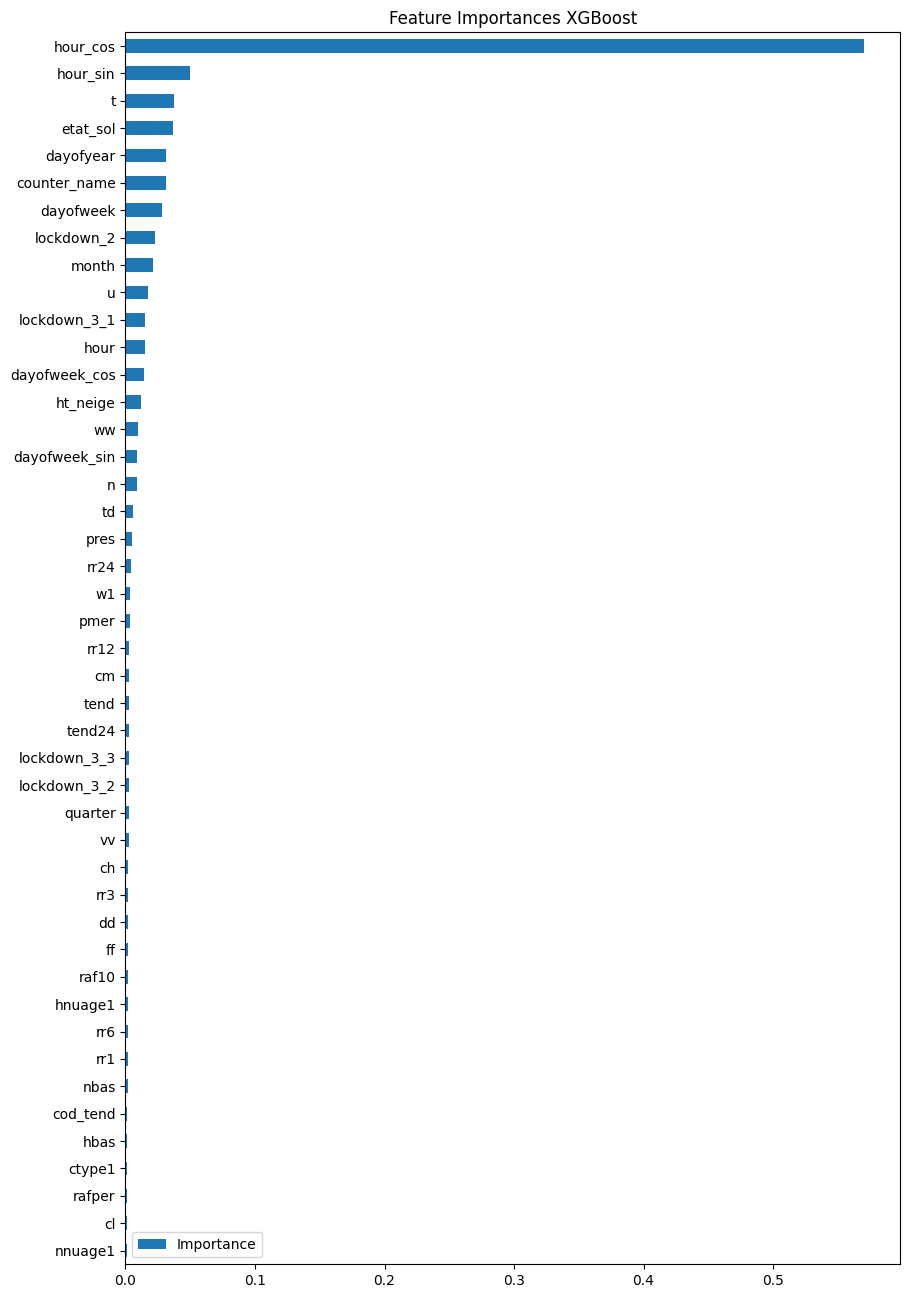

In [55]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [56]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.569862
hour_sin,0.050152
t,0.037480
etat_sol,0.036742
dayofyear,0.031364
counter_name,0.031011
dayofweek,0.028258
lockdown_2,0.022533
month,0.021562
u,0.017723


In [57]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5224449	test: 1.5222930	test1: 1.3416216	best: 1.3416216 (0)	total: 108ms	remaining: 1m 48s
10:	learn: 0.8725063	test: 0.8710305	test1: 0.7388844	best: 0.7388844 (10)	total: 1.03s	remaining: 1m 32s
20:	learn: 0.7548682	test: 0.7524453	test1: 0.6408916	best: 0.6408916 (20)	total: 2.03s	remaining: 1m 34s
30:	learn: 0.7137316	test: 0.7110841	test1: 0.6056981	best: 0.6056981 (30)	total: 3.06s	remaining: 1m 35s
40:	learn: 0.6694586	test: 0.6659207	test1: 0.5882707	best: 0.5882707 (40)	total: 4.11s	remaining: 1m 36s
50:	learn: 0.6537362	test: 0.6499574	test1: 0.5802859	best: 0.5802859 (50)	total: 5.24s	remaining: 1m 37s
60:	learn: 0.6356499	test: 0.6318088	test1: 0.5707073	best: 0.5707073 (60)	total: 6.33s	remaining: 1m 37s
70:	learn: 0.6203375	test: 0.6154800	test1: 0.5660105	best: 0.5660105 (70)	total: 7.45s	remaining: 1m 37s
80:	learn: 0.6076388	test: 0.6020770	test1: 0.5604193	best: 0.5604193 (80)	total: 8.57s	remaining: 1m 37s
90:	learn: 0.59934

In [58]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.45954545283228304
CAT Test: 0.4721560941643482


In [59]:
X_train.shape

(455163, 45)

In [60]:
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feature)

In [61]:
params = {
    "boosting_type": "gbdt",  # Gradient boosting
    "objective": "regression",  # Task is regression
    "metric": {"l2", "l1"},  # Evaluation metrics
    "num_leaves": 31,  # Number of leaves in full tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used in each iteration
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 10,  # Verbosity of output
}

In [62]:
lgbm = lgb.train(params, d_train, num_boost_round=100)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.826905
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.218007
[LightGBM] [Debug] init for col-wise cost 0.009576 seconds, init for row-wise cost 0.021026 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 455163, number of used features: 45
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 3.048589
[LightGBM] [Debug] Re-bagging, using 364176 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth 

In [63]:
y_pred_lgbm = lgbm.predict(X_test)


rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print("LightGBM Test:", rmse_lgbm)

LightGBM Test: 0.4810168843600634


Hyperparameter tuning XGBoost

In [64]:
def objective_xgb(trial):
    # Hyperparameter search space
    params = {
        "tree_method": "hist",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []  # Store RMSE scores for each fold

    for train_index, val_index in tscv.split(X_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBRegressor(**params, enable_categorical=True)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False,
        )

        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # Calculate the average RMSE over all folds
    avg_rmse = np.mean(rmse_scores)

    return avg_rmse

In [66]:
# study_xgb = optuna.create_study(direction="minimize")
# study_xgb.optimize(objective_xgb, n_trials=100)

In [68]:
# best_params = study_xgb.best_params
# print("Best Hyperparameters:", best_params)

In [67]:
best_params = {
    "lambda": 5.5163638658795495,
    "alpha": 5.722067076221477e-06,
    "colsample_bytree": 0.5588623654042607,
    "subsample": 0.7939924932498187,
    "learning_rate": 0.08132063380230384,
    "max_depth": 10,
    "min_child_weight": 132,
}

In [69]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.99695
[10]	validation_0-rmse:1.35990
[20]	validation_0-rmse:0.72788
[30]	validation_0-rmse:0.51678
[40]	validation_0-rmse:0.46505
[50]	validation_0-rmse:0.45256
[60]	validation_0-rmse:0.44460
[70]	validation_0-rmse:0.43214
[80]	validation_0-rmse:0.42709
[90]	validation_0-rmse:0.42531
[99]	validation_0-rmse:0.42150


XGBRegressor(alpha=5.722067076221477e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5588623654042607, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5.5163638658795495,
             learning_rate=0.08132063380230384, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=132, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

In [70]:
y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model Test RMSE: 0.42150242342737554


In [71]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

Final Model  Train RMSE: 0.3602418515775332


<Axes: >

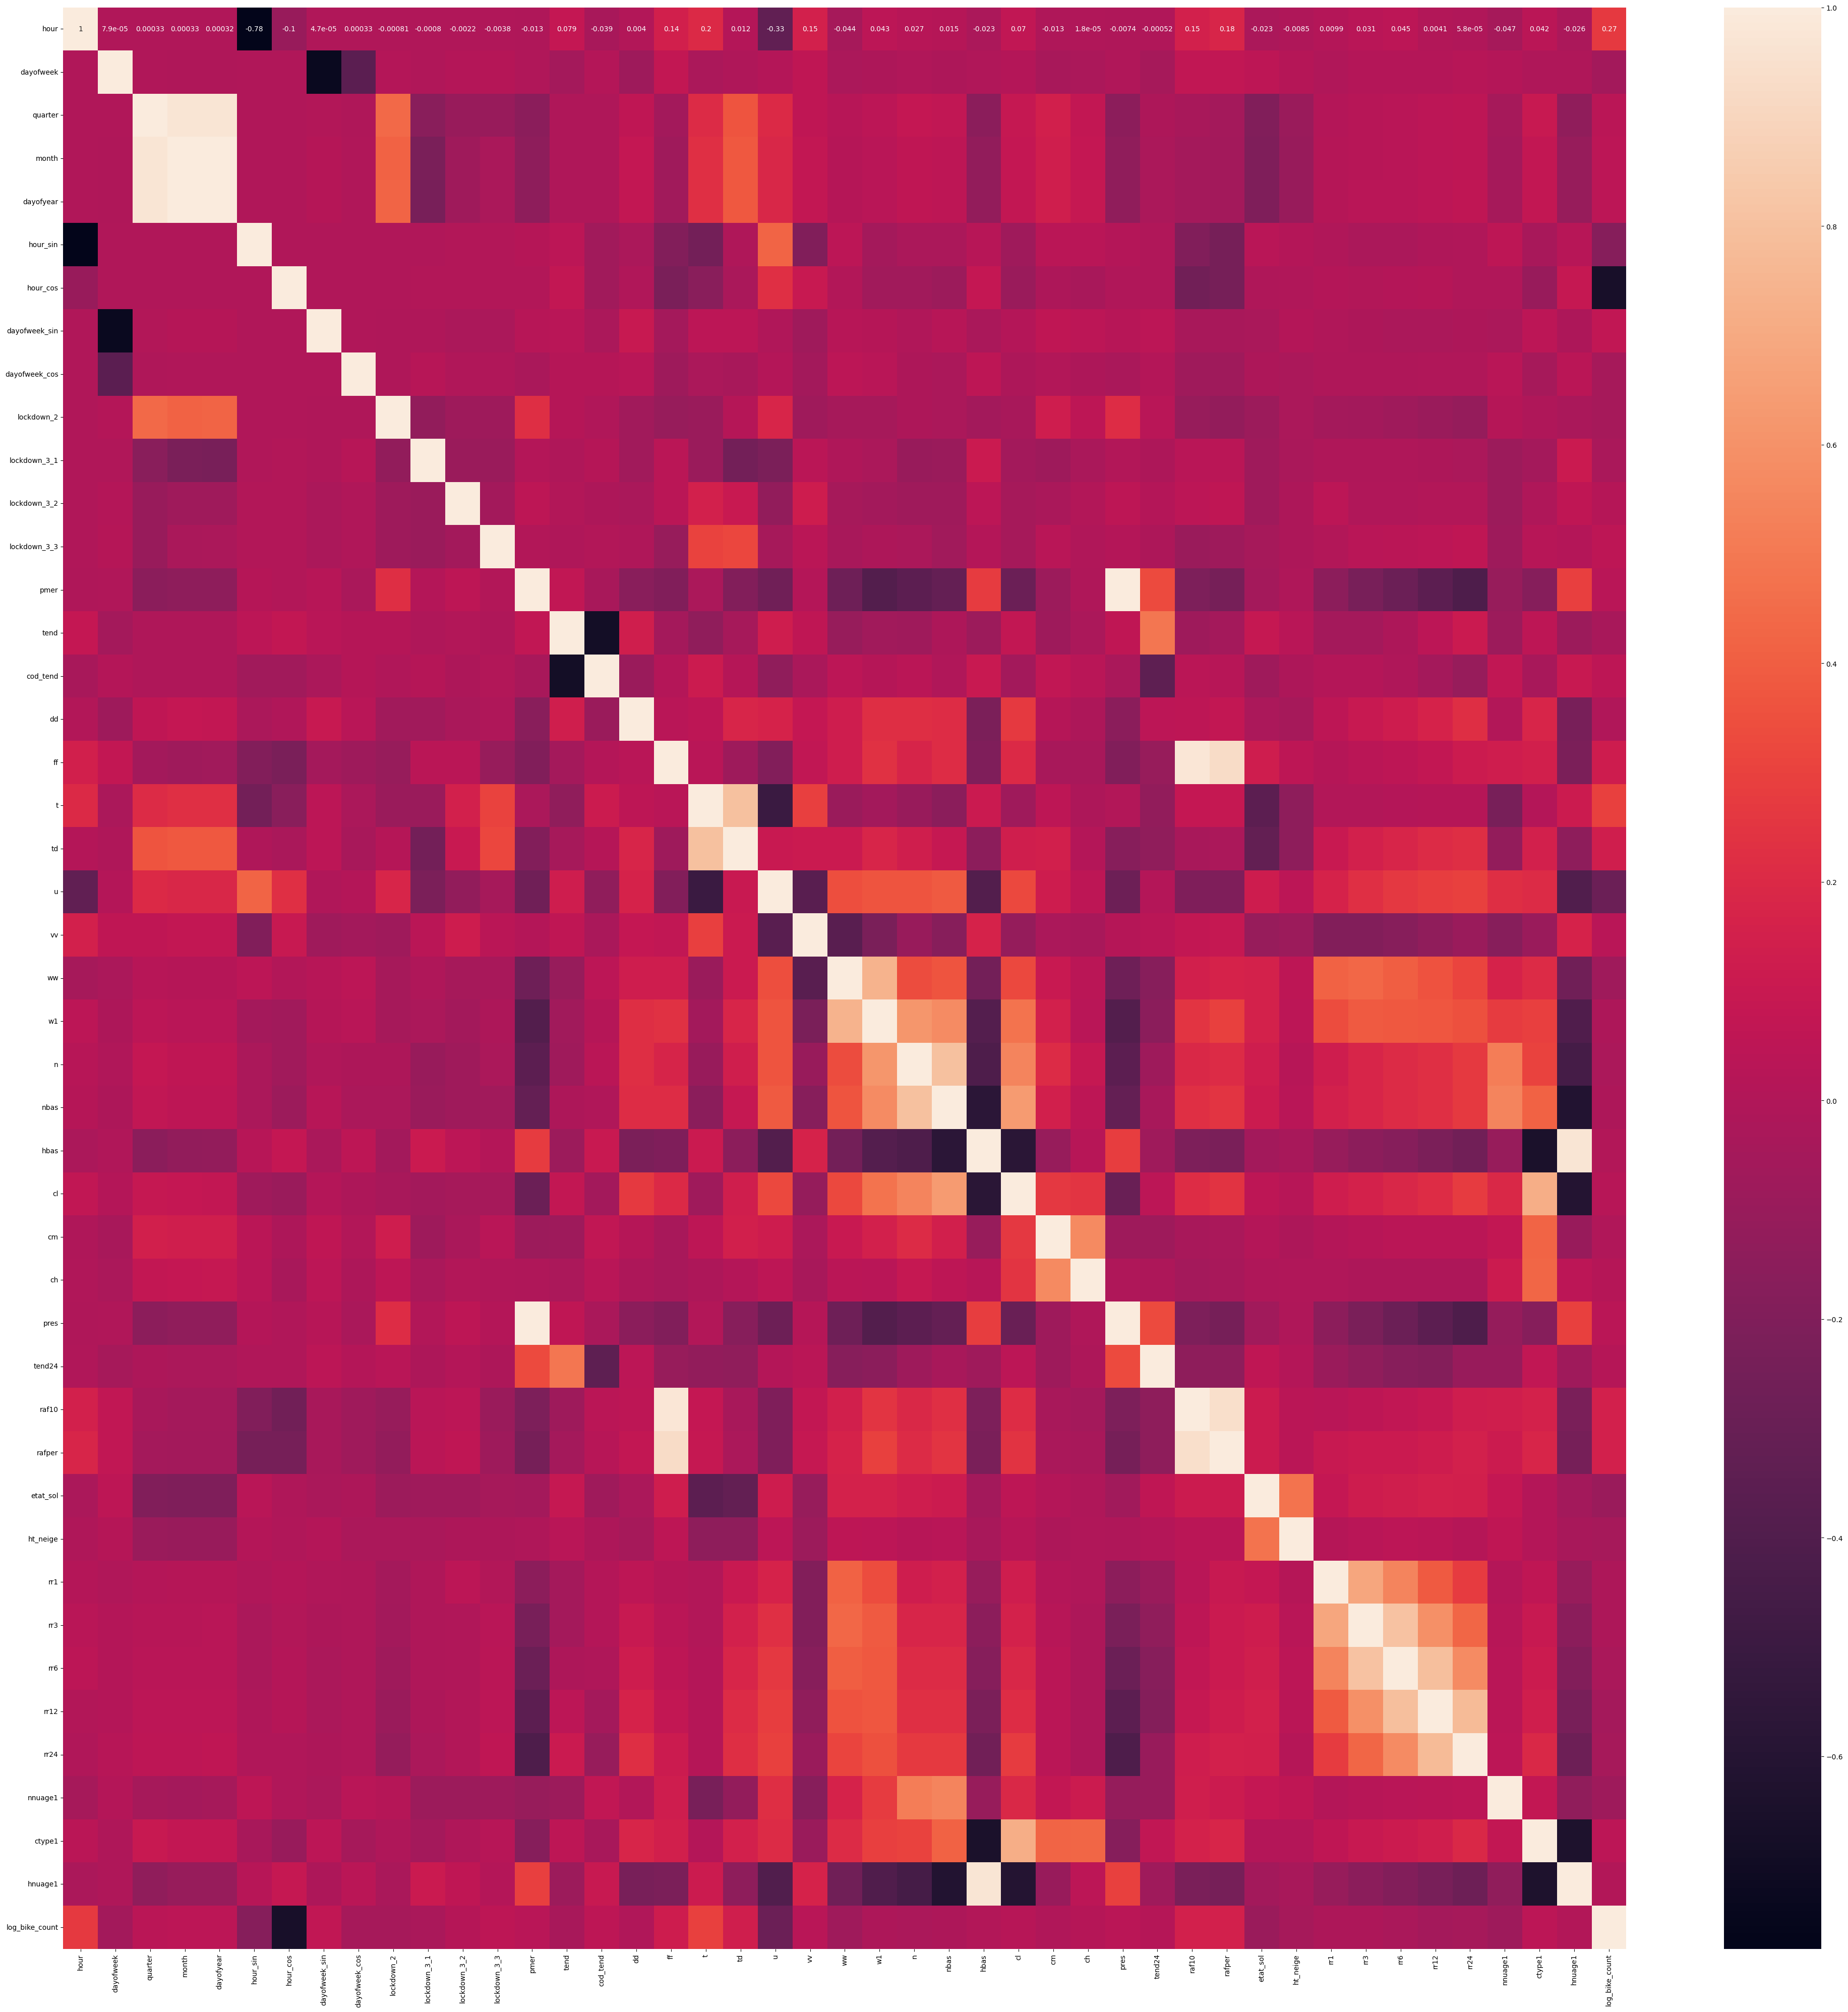

In [76]:
correlation = combined_train[features[1:] + target].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(correlation, annot=True)

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_feature)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feature)

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)

In [ ]:
rfecv = RFECV(estimator=final_model, step=1, cv=5,
              scoring="neg_mean_squared_error")

In [ ]:
rfecv.fit(X_train_encoded, y_train)

In [ ]:
optimal_features = X_train_encoded.columns[rfecv.support_]

In [ ]:
optimal_features

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "tend",
    "t",
    "td",
    "u",
    "ww",
    "n",
    "tend24",
    "etat_sol",
    "rr12",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

# Interactions & Lags

In [17]:
combined_train["temp_hour_interaction"] = combined_train["t"] * \
    combined_train["hour"]



combined_train["humidity_day_interaction"] = (

    combined_train["u"] * combined_train["dayofweek"]

)

In [18]:
combined_test["temp_hour_interaction"] = combined_test["t"] * \
    combined_test["hour"]





combined_test["humidity_day_interaction"] = (

    combined_test["u"] * combined_test["dayofweek"]

)

In [95]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "tend",
    "t",
    "td",
    "u",
    "ww",
    "n",
    "tend24",
    "etat_sol",
    "rr12",
    "ctype1",
    "hnuage1",
    "temp_hour_interaction",
    "humidity_day_interaction",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag24h",
    "td_lag6h",
    "td_lag9h",
    "td_lag24h",
    "u_lag6h",
    "u_lag9h",
    "u_lag24h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag24h",
    "n_lag6h",
    "n_lag9h",
    "n_lag24h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag24h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag24h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag24h",
    "t_lag12h",
    "td_lag12h",
    "u_lag12h",
    "ww_lag12h",
    "n_lag12h",
    "tend24_lag12h",
    "etat_sol_lag12h",
    "rr12_lag12h",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [82]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [83]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.99679
[10]	validation_0-rmse:1.37917
[20]	validation_0-rmse:0.72355
[30]	validation_0-rmse:0.51800
[40]	validation_0-rmse:0.46078
[50]	validation_0-rmse:0.44341
[60]	validation_0-rmse:0.43198
[70]	validation_0-rmse:0.42157
[80]	validation_0-rmse:0.41709
[90]	validation_0-rmse:0.41353
[99]	validation_0-rmse:0.41200


XGBRegressor(alpha=5.722067076221477e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5588623654042607, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5.5163638658795495,
             learning_rate=0.08132063380230384, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=132, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

In [84]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.3596373340451227
Final Model Test RMSE: 0.41200160872598174


<Axes: title={'center': 'Feature Importances XGBoost'}>

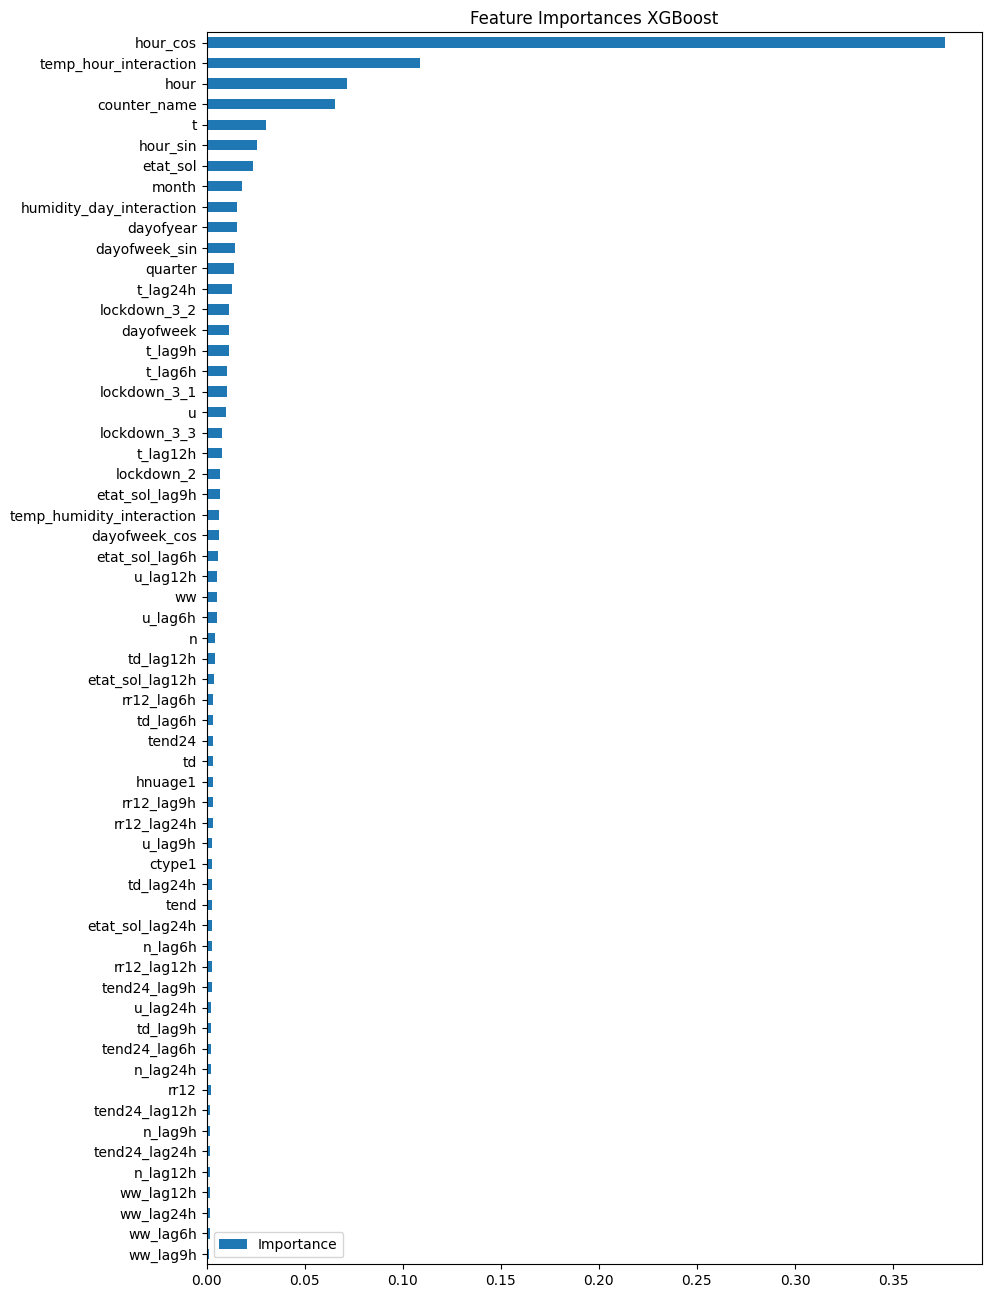

In [85]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [86]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.376423
temp_hour_interaction,0.108736
hour,0.071470
counter_name,0.065637
t,0.030147
hour_sin,0.025608
etat_sol,0.023678
month,0.018002
humidity_day_interaction,0.015432
dayofyear,0.015252


In [87]:
from sklearn.utils import resample

Bootstrapping to get average feature importances with std

In [88]:
num_bootstraps = 100
feature_importances = np.zeros((num_bootstraps, len(X_train.columns)))

In [89]:
for i in range(num_bootstraps):
    # Create a bootstrap sample
    X_sample, y_sample = resample(X_train, y_train)

    # Fit the model
    model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True)
    model.fit(X_sample, y_sample)

    # Store the feature importances
    feature_importances[i, :] = model.feature_importances_

In [90]:
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

In [91]:
mean_importances

array([0.02129656, 0.00664225, 0.01955236, 0.00171005, 0.01346255,
       0.02710082, 0.0275274 , 0.57512465, 0.00338992, 0.01000774,
       0.01035836, 0.00808434, 0.0023186 , 0.00524573, 0.00141828,
       0.02090894, 0.00232852, 0.00688737, 0.00622244, 0.00807661,
       0.00322019, 0.03869595, 0.00199222, 0.00172053, 0.00158758,
       0.0370276 , 0.02696725, 0.0026803 , 0.00539664, 0.00995278,
       0.01799141, 0.00209157, 0.00201138, 0.00217555, 0.00230819,
       0.00166503, 0.00159058, 0.00111986, 0.00114345, 0.00115918,
       0.00223947, 0.00114708, 0.00106004, 0.00204893, 0.00145322,
       0.00140074, 0.01104413, 0.0016399 , 0.00176317, 0.00221145,
       0.00201965, 0.00190666, 0.01718958, 0.00220842, 0.00202261,
       0.00119782, 0.00132637, 0.00154331, 0.00297218, 0.00144455])

In [92]:
std_importances

array([0.00108886, 0.00088166, 0.00203644, 0.00066363, 0.00322028,
       0.00226321, 0.00472909, 0.02033499, 0.00091162, 0.00252818,
       0.00417313, 0.00226445, 0.00111499, 0.00270373, 0.00024482,
       0.00393393, 0.00080792, 0.00261571, 0.001254  , 0.00164498,
       0.00064929, 0.00847315, 0.0005671 , 0.00061181, 0.00048565,
       0.00391749, 0.0025724 , 0.00114788, 0.00169515, 0.00421526,
       0.00382488, 0.00064243, 0.00060198, 0.00063817, 0.00064591,
       0.00043331, 0.00028354, 0.00029162, 0.00028992, 0.00044357,
       0.00075274, 0.00055833, 0.00033558, 0.00044713, 0.00033442,
       0.00021244, 0.0046989 , 0.00125872, 0.00195454, 0.00070576,
       0.0006574 , 0.0003996 , 0.0038231 , 0.00071758, 0.00054396,
       0.00025666, 0.0004554 , 0.00036132, 0.00122338, 0.00050137])

In [93]:
model.feature_names_in_

array(['counter_name', 'hour', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'hour_sin', 'hour_cos', 'dayofweek_sin',
       'dayofweek_cos', 'lockdown_2', 'lockdown_3_1', 'lockdown_3_2',
       'lockdown_3_3', 'tend', 't', 'td', 'u', 'ww', 'n', 'tend24',
       'etat_sol', 'rr12', 'ctype1', 'hnuage1', 'temp_hour_interaction',
       'humidity_day_interaction', 'temp_humidity_interaction', 't_lag6h',
       't_lag9h', 't_lag24h', 'td_lag6h', 'td_lag9h', 'td_lag24h',
       'u_lag6h', 'u_lag9h', 'u_lag24h', 'ww_lag6h', 'ww_lag9h',
       'ww_lag24h', 'n_lag6h', 'n_lag9h', 'n_lag24h', 'tend24_lag6h',
       'tend24_lag9h', 'tend24_lag24h', 'etat_sol_lag6h',
       'etat_sol_lag9h', 'etat_sol_lag24h', 'rr12_lag6h', 'rr12_lag9h',
       'rr12_lag24h', 't_lag12h', 'td_lag12h', 'u_lag12h', 'ww_lag12h',
       'n_lag12h', 'tend24_lag12h', 'etat_sol_lag12h', 'rr12_lag12h'],
      dtype='<U25')

# Best XGBoost Model

In [25]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "quarter",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "u",
    "ww",
    "n",
    "etat_sol",
    "rr12",
    "temp_hour_interaction",
    "humidity_day_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag24h",
    "td_lag24h",
    "u_lag24h",
    "ww_lag24h",
    "n_lag24h",
    "etat_sol_lag24h",
    "rr12_lag24h",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [26]:
train_filtered = combined_train[features]

In [27]:
train_filtered["log_bike_count"] = combined_train[target]

In [28]:
train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 01:00:00 to 2021-08-09 23:00:00
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   counter_name              455163 non-null  category
 1   hour                      455163 non-null  int32   
 2   dayofweek                 455163 non-null  int32   
 3   month                     455163 non-null  int32   
 4   quarter                   455163 non-null  int32   
 5   dayofyear                 455163 non-null  int32   
 6   hour_sin                  455163 non-null  float64 
 7   hour_cos                  455163 non-null  float64 
 8   dayofweek_sin             455163 non-null  float64 
 9   dayofweek_cos             455163 non-null  float64 
 10  lockdown_2                455163 non-null  int32   
 11  lockdown_3_1              455163 non-null  int32   
 12  lockdown_3_2              455163 non-null  int32   


In [29]:
from scipy import stats

skewness = stats.skew(train_filtered["log_bike_count"])
print(f"Skewness of 'log_bike_count': {skewness}")

Skewness of 'log_bike_count': -0.30408148197229656


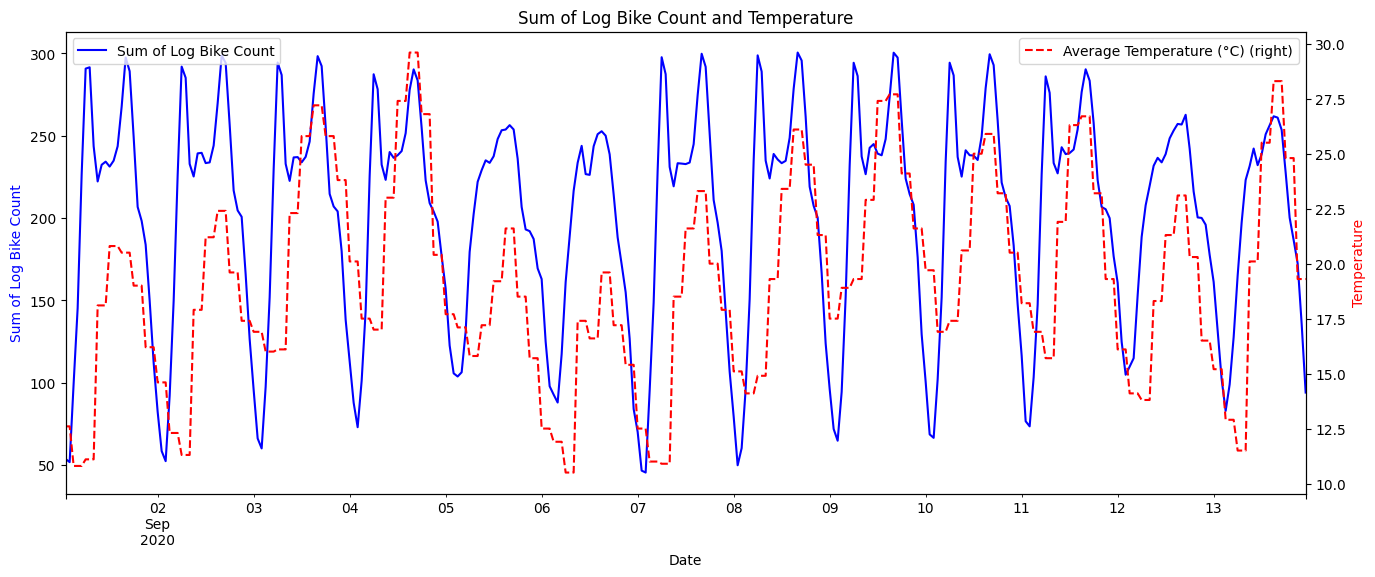

In [66]:
# Make sure 'train_filtered' is your DataFrame with the appropriate DateTimeIndex.

# Filter the data for the dates of interest in June 2021.
mask = (train_filtered.index >= "2020-09-01") & (train_filtered.index < "2020-09-14")

# Group by date, sum the 'log_bike_count', and average the 't' (temperature) across all counters.
aggregated_data = (
    train_filtered[mask].resample("H").agg({"log_bike_count": "sum", "t": "mean"})
)

# Create the plot with the specified size.
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the 'log_bike_count' on y-axis.
aggregated_data["log_bike_count"].plot(
    ax=ax, label="Sum of Log Bike Count", color="blue"
)

# Plot the 'temperature' on the same y-axis with secondary_y to create another y-axis.
(aggregated_data["t"] - 273.15).plot(
    ax=ax,
    label="Average Temperature (°C)",
    color="red",
    linestyle="--",
    secondary_y=True,
)

# Set labels and title.
ax.set_xlabel("Date")
ax.set_ylabel("Sum of Log Bike Count", color="blue")
ax.right_ax.set_ylabel("Temperature", color="red")

# Set the legend position.
ax.legend(loc="upper left")
ax.right_ax.legend(loc="upper right")

# Show the plot.
plt.title("Sum of Log Bike Count and Temperature")
plt.show()

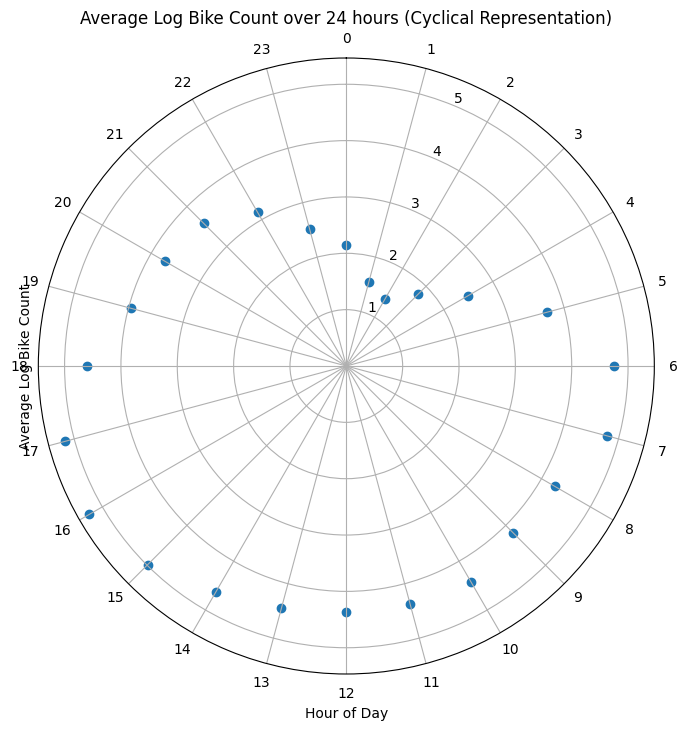

In [65]:
# Group by both 'hour_sin' and 'hour_cos' to calculate the average 'log_bike_count'.
grouped_data = (
    train_filtered[mask]
    .groupby(["hour_sin", "hour_cos"])["log_bike_count"]
    .mean()
    .reset_index()
)

# Convert 'hour_sin' and 'hour_cos' into an angle in radians for the polar plot
# Calculate the angle by using the arctan2 function which takes into account the sign of both arguments to determine the correct quadrant.
grouped_data["angle"] = np.arctan2(
    grouped_data["hour_sin"], grouped_data["hour_cos"])

# Create a polar plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Plot the data: 'angle' for the theta-axis and 'log_bike_count' for the radius
ax.scatter(grouped_data["angle"], grouped_data["log_bike_count"])

# Set the theta direction to clockwise and theta offset to have midnight at the top
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

# Set labels for the 24 hours
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))

# Set the title and labels
ax.set_title("Average Log Bike Count over 24 hours (Cyclical Representation)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Log Bike Count")

# Show the plot
plt.show()

In [68]:
# Filter rows where 'log_bike_count' is 0
zero_bike_counts = train_filtered[train_filtered["log_bike_count"] == 0]

# Count the number of zero 'log_bike_count' entries for each 'counter_name'
zero_counts_per_counter = zero_bike_counts["counter_name"].value_counts()

# Get the 'counter_name' with the most zeros
counter_with_most_zeros = zero_counts_per_counter.idxmax()

# Print the result
print(
    f"The counter with the most number of rows with log_bike_count as 0 is: {counter_with_most_zeros}"
)

The counter with the most number of rows with log_bike_count as 0 is: 28 boulevard Diderot E-O


In [21]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [92]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.1, 1, step=0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = xgb.XGBRegressor(tree_method="hist", **
                             param, enable_categorical=True)

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_index, test_index in tscv.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_test_fold, y_test_fold)],
            early_stopping_rounds=50,
            verbose=False,
        )
        predictions = model.predict(X_test_fold)
        score = mean_squared_error(
            y_test_fold, predictions, squared=False)  # RMSE
        scores.append(score)

    return np.mean(scores)

In [ ]:
# study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

In [ ]:
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)

In [67]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

In [99]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20607
[10]	validation_0-rmse:2.70955
[20]	validation_0-rmse:2.28909
[30]	validation_0-rmse:1.93403
[40]	validation_0-rmse:1.64076
[50]	validation_0-rmse:1.39825
[60]	validation_0-rmse:1.20053
[70]	validation_0-rmse:1.04001
[80]	validation_0-rmse:0.91205
[90]	validation_0-rmse:0.81633
[100]	validation_0-rmse:0.72923
[110]	validation_0-rmse:0.65399
[120]	validation_0-rmse:0.59808
[130]	validation_0-rmse:0.55166
[140]	validation_0-rmse:0.52142
[150]	validation_0-rmse:0.49593
[160]	validation_0-rmse:0.47681
[170]	validation_0-rmse:0.46681
[180]	validation_0-rmse:0.45694
[190]	validation_0-rmse:0.44938
[200]	validation_0-rmse:0.44229
[210]	validation_0-rmse:0.43803
[220]	validation_0-rmse:0.43184
[230]	validation_0-rmse:0.42702
[240]	validation_0-rmse:0.42285
[250]	validation_0-rmse:0.41841
[260]	validation_0-rmse:0.41574
[270]	validation_0-rmse:0.41358
[280]	validation_0-rmse:0.41234
[290]	validation_0-rmse:0.41067
[300]	validation_0-rmse:0.40914
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [100]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.32131183589659434
Final Model Test RMSE: 0.39992724569594207


<Axes: title={'center': 'Feature Importances XGBoost'}>

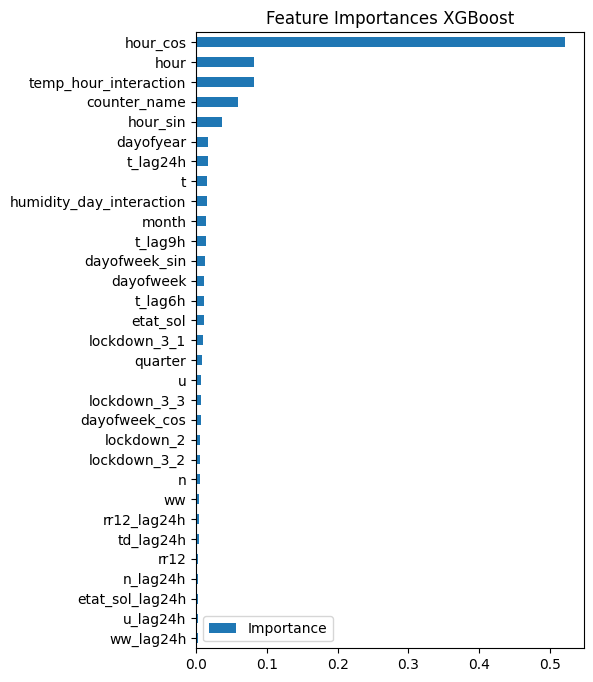

In [104]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(5, 8)
)

In [101]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag12h",
    "t_lag24h",
    "t_lag168h",
    "td_lag6h",
    "td_lag9h",
    "td_lag12h",
    "td_lag24h",
    "td_lag168h",
    "u_lag6h",
    "u_lag9h",
    "u_lag12h",
    "u_lag24h",
    "u_lag168h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag12h",
    "ww_lag24h",
    "ww_lag168h",
    "n_lag6h",
    "n_lag9h",
    "n_lag12h",
    "n_lag24h",
    "n_lag168h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag12h",
    "tend24_lag24h",
    "tend24_lag168h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag12h",
    "etat_sol_lag24h",
    "etat_sol_lag168h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag12h",
    "rr12_lag24h",
    "rr12_lag168h",
    "temp_hour_interaction",
    "humidity_day_interaction",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [103]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [104]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20280
[10]	validation_0-rmse:2.70235
[20]	validation_0-rmse:2.27959
[30]	validation_0-rmse:1.93341
[40]	validation_0-rmse:1.65007
[50]	validation_0-rmse:1.39649
[60]	validation_0-rmse:1.19830
[70]	validation_0-rmse:1.03022
[80]	validation_0-rmse:0.90433
[90]	validation_0-rmse:0.79653
[100]	validation_0-rmse:0.70716
[110]	validation_0-rmse:0.63392
[120]	validation_0-rmse:0.58136
[130]	validation_0-rmse:0.54330
[140]	validation_0-rmse:0.51418
[150]	validation_0-rmse:0.49309
[160]	validation_0-rmse:0.47716
[170]	validation_0-rmse:0.46279
[180]	validation_0-rmse:0.45130
[190]	validation_0-rmse:0.44380
[200]	validation_0-rmse:0.43751
[210]	validation_0-rmse:0.43297
[220]	validation_0-rmse:0.43010
[230]	validation_0-rmse:0.42793
[240]	validation_0-rmse:0.42615
[250]	validation_0-rmse:0.42467
[260]	validation_0-rmse:0.42323
[270]	validation_0-rmse:0.42167
[280]	validation_0-rmse:0.42102
[290]	validation_0-rmse:0.42075
[300]	validation_0-rmse:0.41967
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [105]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.31904627556223036
Final Model Test RMSE: 0.41499627585029536


<Axes: title={'center': 'Feature Importances XGBoost'}>

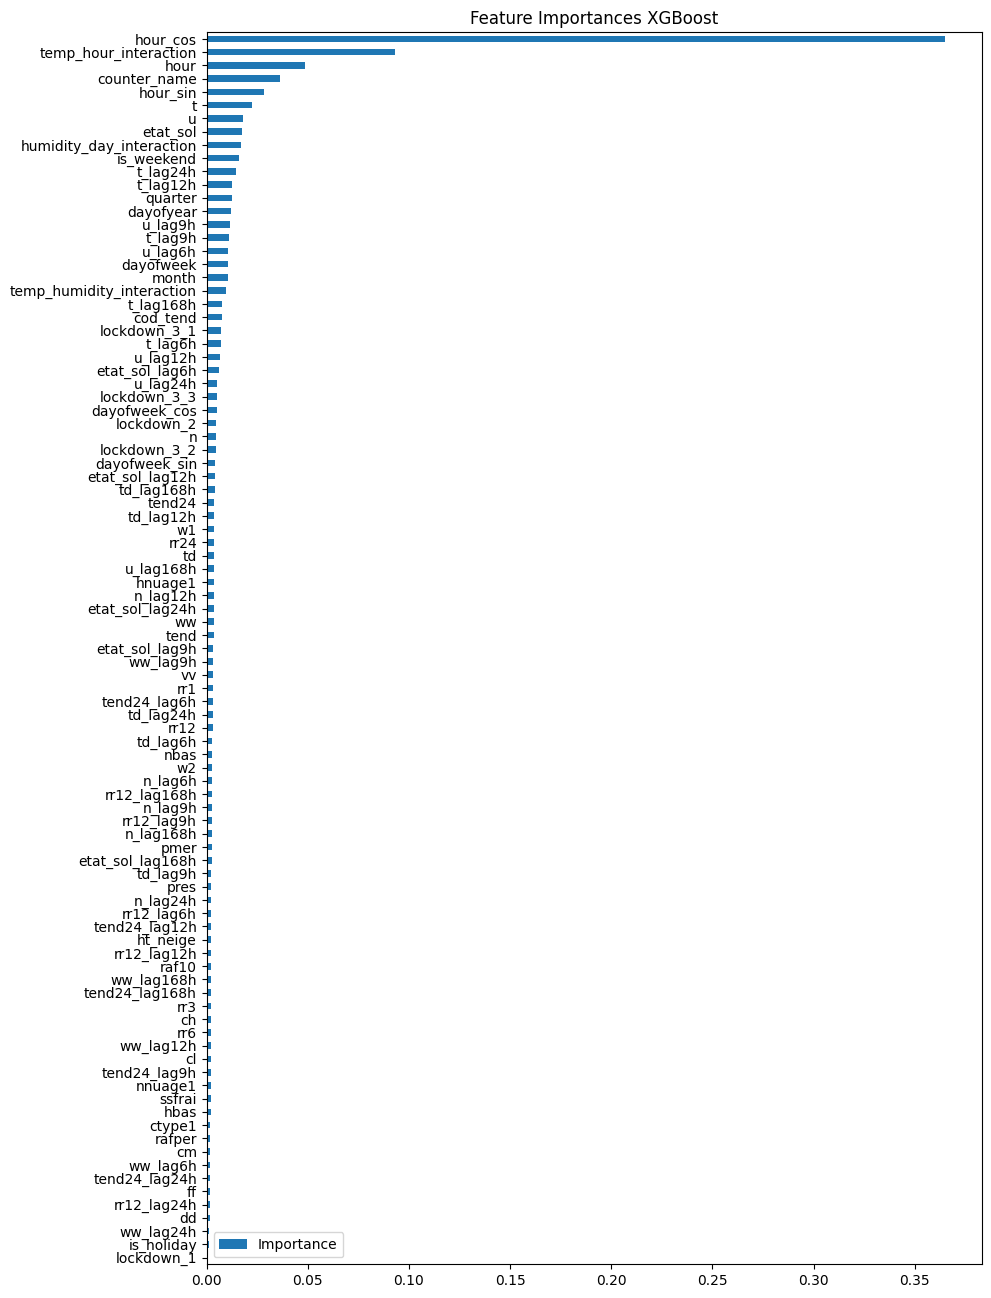

In [106]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [107]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.364907
temp_hour_interaction,0.092898
hour,0.048799
counter_name,0.036113
hour_sin,0.028379
...,...
rr12_lag24h,0.001714
dd,0.001410
ww_lag24h,0.001265
is_holiday,0.001119


In [109]:
fi.to_csv("feature_importances_xgb_weather.csv")

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_feature)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feature)

In [ ]:
model = xgb.XGBRegressor()

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=10,
    n_jobs=-1,
)

In [ ]:
rfecv.fit(X_train_encoded, y_train)

In [ ]:
optimal_features = X_train_encoded.columns[rfecv.support_]

In [115]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag12h",
    "t_lag24h",
    "t_lag168h",
    "td_lag6h",
    "td_lag9h",
    "td_lag12h",
    "td_lag24h",
    "td_lag168h",
    "u_lag6h",
    "u_lag9h",
    "u_lag12h",
    "u_lag24h",
    "u_lag168h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag12h",
    "ww_lag24h",
    "ww_lag168h",
    "n_lag6h",
    "n_lag9h",
    "n_lag12h",
    "n_lag24h",
    "n_lag168h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag12h",
    "tend24_lag24h",
    "tend24_lag168h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag12h",
    "etat_sol_lag24h",
    "etat_sol_lag168h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag12h",
    "rr12_lag24h",
    "rr12_lag168h",
    "temp_hour_interaction",
    "humidity_day_interaction",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [116]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [117]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21087	validation_1-rmse:2.35740
[10]	validation_0-rmse:0.58353	validation_1-rmse:0.53265
[20]	validation_0-rmse:0.48228	validation_1-rmse:0.46666
[30]	validation_0-rmse:0.44819	validation_1-rmse:0.46124
[40]	validation_0-rmse:0.43251	validation_1-rmse:0.45068
[50]	validation_0-rmse:0.42178	validation_1-rmse:0.45112
[51]	validation_0-rmse:0.42027	validation_1-rmse:0.45116


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [118]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.4300467282480357
XGB Test: 0.44981021013776473


In [119]:
feature_importances = reg.feature_importances_
feature_names = X_train.columns
features_ranked = sorted(
    zip(feature_names, feature_importances), key=lambda x: x[1])

In [120]:
features_ranked

[('is_weekend', 0.0),
 ('lockdown_1', 0.0),
 ('w2', 0.0),
 ('ssfrai', 0.0),
 ('is_holiday', 0.0003918867),
 ('ww_lag168h', 0.00044726144),
 ('n_lag24h', 0.0004696902),
 ('n_lag12h', 0.0005274656),
 ('ww_lag24h', 0.000551582),
 ('rr12_lag9h', 0.0007329887),
 ('rr1', 0.0007430816),
 ('cod_tend', 0.0007826709),
 ('n_lag168h', 0.0008423149),
 ('nnuage1', 0.0008425423),
 ('rr6', 0.00089278346),
 ('u_lag168h', 0.0009454478),
 ('ww_lag12h', 0.0009750048),
 ('hbas', 0.0009901777),
 ('tend24_lag12h', 0.0010003218),
 ('ch', 0.0010233342),
 ('tend24_lag24h', 0.0010269076),
 ('n_lag9h', 0.0010562574),
 ('rr12', 0.001128645),
 ('rr12_lag6h', 0.0011562145),
 ('ff', 0.0011957203),
 ('tend24_lag9h', 0.0012160337),
 ('etat_sol_lag24h', 0.001222344),
 ('pmer', 0.0012341207),
 ('etat_sol_lag168h', 0.0012723396),
 ('rafper', 0.0012972621),
 ('cm', 0.0014475528),
 ('cl', 0.0014608977),
 ('hnuage1', 0.0014956353),
 ('td_lag6h', 0.0015068403),
 ('tend24_lag6h', 0.0015077039),
 ('dd', 0.0016433542),
 ('ww_lag

In [121]:
performance_history = []

In [122]:
for i in range(len(features_ranked)):
    # Remove the least important feature
    features_to_use = [f[0] for f in features_ranked[i:]]
    X_train_reduced = X_train[features_to_use]
    X_test_reduced = X_test[features_to_use]

    # Retrain the model
    reg.fit(
        X_train_reduced,
        y_train,
        eval_set=[(X_test_reduced, y_test)],
        early_stopping_rounds=10,
    )

    # Evaluate performance
    predictions = reg.predict(X_test_reduced)
    current_performance = mean_squared_error(
        y_test, predictions, squared=False)

    # Store the performance
    performance_history.append((len(features_to_use), current_performance))

[0]	validation_0-rmse:2.35740
[1]	validation_0-rmse:1.73051
[2]	validation_0-rmse:1.27971
[3]	validation_0-rmse:0.99375
[4]	validation_0-rmse:0.79394
[5]	validation_0-rmse:0.68162
[6]	validation_0-rmse:0.62745
[7]	validation_0-rmse:0.58123
[8]	validation_0-rmse:0.55969
[9]	validation_0-rmse:0.54051
[10]	validation_0-rmse:0.53265
[11]	validation_0-rmse:0.52351
[12]	validation_0-rmse:0.51969
[13]	validation_0-rmse:0.48729
[14]	validation_0-rmse:0.48644
[15]	validation_0-rmse:0.48040
[16]	validation_0-rmse:0.47586
[17]	validation_0-rmse:0.47610
[18]	validation_0-rmse:0.47479
[19]	validation_0-rmse:0.46940
[20]	validation_0-rmse:0.46666
[21]	validation_0-rmse:0.46616
[22]	validation_0-rmse:0.46614
[23]	validation_0-rmse:0.46229
[24]	validation_0-rmse:0.46203
[25]	validation_0-rmse:0.46257
[26]	validation_0-rmse:0.46240
[27]	validation_0-rmse:0.46361
[28]	validation_0-rmse:0.46444
[29]	validation_0-rmse:0.46418
[30]	validation_0-rmse:0.46151
[31]	validation_0-rmse:0.46027
[32]	validation_0-

In [123]:
performance_df = pd.DataFrame(
    performance_history, columns=["Num_Features", "Performance"]
)

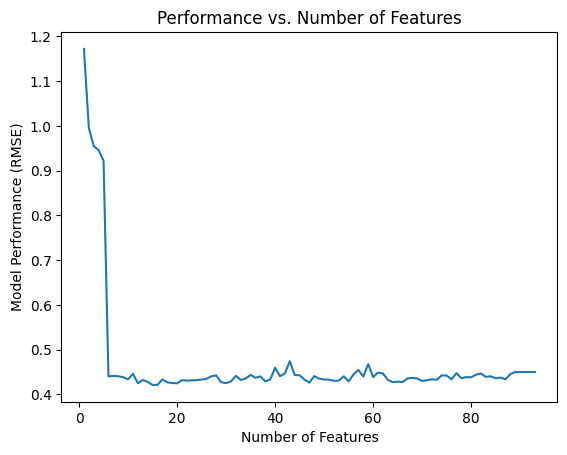

In [124]:
plt.plot(performance_df["Num_Features"], performance_df["Performance"])
plt.xlabel("Number of Features")
plt.ylabel("Model Performance (RMSE)")
plt.title("Performance vs. Number of Features")
plt.show()

In [125]:
performance_df.to_csv("feature performance.csv")

In [126]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag12h",
    "t_lag24h",
    "t_lag168h",
    "td_lag6h",
    "td_lag9h",
    "td_lag12h",
    "td_lag24h",
    "td_lag168h",
    "u_lag6h",
    "u_lag9h",
    "u_lag12h",
    "u_lag24h",
    "u_lag168h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag12h",
    "ww_lag24h",
    "ww_lag168h",
    "n_lag6h",
    "n_lag9h",
    "n_lag12h",
    "n_lag24h",
    "n_lag168h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag12h",
    "tend24_lag24h",
    "tend24_lag168h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag12h",
    "etat_sol_lag24h",
    "etat_sol_lag168h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag12h",
    "rr12_lag24h",
    "rr12_lag168h",
    "temp_hour_interaction",
    "humidity_day_interaction",
]

target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [127]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [128]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1500, enable_categorical=True)



reg.fit(
    X_train,
    y_train,

    eval_set=[(X_train, y_train), (X_test, y_test)],

    early_stopping_rounds=10,

    verbose=10,
)

[0]	validation_0-rmse:2.21087	validation_1-rmse:2.35740
[10]	validation_0-rmse:0.58353	validation_1-rmse:0.53265
[20]	validation_0-rmse:0.48228	validation_1-rmse:0.46666
[30]	validation_0-rmse:0.44819	validation_1-rmse:0.46124
[40]	validation_0-rmse:0.43251	validation_1-rmse:0.45068
[50]	validation_0-rmse:0.42178	validation_1-rmse:0.45112
[51]	validation_0-rmse:0.42027	validation_1-rmse:0.45116


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [129]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.4300467282480357
XGB Test: 0.44981021013776473


In [130]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.486185
temp_hour_interaction,0.045241
humidity_day_interaction,0.028359
t,0.028141
dayofyear,0.023941
...,...
n_lag24h,0.000470
ww_lag168h,0.000447
is_holiday,0.000392
w2,0.000000


In [131]:
features = [
    "hour_cos",
    "temp_hour_interaction",
    "humidity_day_interaction",
    "etat_sol",
    "counter_name",
    "dayofyear",
    "hour_sin",
    "t_lag168h",
    "etat_sol_lag6h",
    "t",
    "t_lag12h",
    "t_lag9h",
    "w1",
    "dayofweek",
    "n",
    "month",
    "t_lag24h",
    "lockdown_2",
    "ww",
    "u",
    "lockdown_3_3",
    "ht_neige",
    "t_lag6h",
    "dayofweek_cos",
    "lockdown_3_1",
    "lockdown_3_2",
    "td_lag12h",
    "hour",
    "rr3",
    "rr24",
    "raf10",
    "dayofweek_sin",
    "n_lag6h",
    "td_lag24h",
    "td_lag168h",
    "etat_sol_lag12h",
    "tend24_lag6h",
    "u_lag9h",
    "etat_sol_lag168h",
    "ww_lag6h",
    "u_lag24h",
    "tend24_lag9h",
    "rr12_lag12h",
    "dd",
    "cl",
    "pres",
    "u_lag12h",
    "u_lag6h",
    "etat_sol_lag9h",
    "rr12_lag168h",
    "tend24",
    "temp_humidity_interaction",
    "rr12_lag24h",
    "td",
    "cm",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [133]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [134]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20548
[10]	validation_0-rmse:2.70461
[20]	validation_0-rmse:2.29195
[30]	validation_0-rmse:1.94696
[40]	validation_0-rmse:1.65142
[50]	validation_0-rmse:1.40156
[60]	validation_0-rmse:1.20673
[70]	validation_0-rmse:1.03335
[80]	validation_0-rmse:0.90761
[90]	validation_0-rmse:0.80740
[100]	validation_0-rmse:0.72309
[110]	validation_0-rmse:0.65393
[120]	validation_0-rmse:0.60229
[130]	validation_0-rmse:0.56453
[140]	validation_0-rmse:0.53700
[150]	validation_0-rmse:0.51479
[160]	validation_0-rmse:0.49511
[170]	validation_0-rmse:0.48022
[180]	validation_0-rmse:0.47143
[190]	validation_0-rmse:0.45670
[200]	validation_0-rmse:0.45132
[210]	validation_0-rmse:0.44681
[220]	validation_0-rmse:0.44114
[230]	validation_0-rmse:0.43739
[240]	validation_0-rmse:0.43400
[250]	validation_0-rmse:0.43218
[260]	validation_0-rmse:0.42914
[270]	validation_0-rmse:0.42544
[280]	validation_0-rmse:0.42377
[290]	validation_0-rmse:0.42227
[300]	validation_0-rmse:0.42067
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [135]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.3228554087174468
Final Model Test RMSE: 0.412349730370805


In [136]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

In [137]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.228950
hour,0.145222
temp_hour_interaction,0.081508
counter_name,0.056344
hour_sin,0.047692
lockdown_3_3,0.033685
t,0.021699
u_lag9h,0.021389
t_lag24h,0.019550
u,0.019346


In [138]:
features = [
    "hour_cos",
    "hour",
    "temp_hour_interaction",
    "counter_name",
    "hour_sin",
    "lockdown_3_3",
    "t",
    "u_lag9h",
    "t_lag24h",
    "u",
    "lockdown_3_2",
    "month",
    "etat_sol",
    "dayofyear",
    "humidity_day_interaction",
    "dayofweek_sin",
    "t_lag9h",
    "temp_humidity_interaction",
    "dayofweek",
    "lockdown_3_1",
    "t_lag12h",
    "t_lag6h",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [139]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [140]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)


final_model.fit(
    X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=10
)

[0]	validation_0-rmse:3.20416
[10]	validation_0-rmse:2.71568
[20]	validation_0-rmse:2.29121
[30]	validation_0-rmse:1.93657
[40]	validation_0-rmse:1.64050
[50]	validation_0-rmse:1.39892
[60]	validation_0-rmse:1.21431
[70]	validation_0-rmse:1.04909
[80]	validation_0-rmse:0.91746
[90]	validation_0-rmse:0.81270
[100]	validation_0-rmse:0.73281
[110]	validation_0-rmse:0.66214
[120]	validation_0-rmse:0.61079
[130]	validation_0-rmse:0.56254
[140]	validation_0-rmse:0.53135
[150]	validation_0-rmse:0.51218
[160]	validation_0-rmse:0.49234
[170]	validation_0-rmse:0.48007
[180]	validation_0-rmse:0.46737
[190]	validation_0-rmse:0.45839
[200]	validation_0-rmse:0.44956
[210]	validation_0-rmse:0.44324
[220]	validation_0-rmse:0.43975
[230]	validation_0-rmse:0.43450
[240]	validation_0-rmse:0.43042
[250]	validation_0-rmse:0.42605
[260]	validation_0-rmse:0.42303
[270]	validation_0-rmse:0.42125
[280]	validation_0-rmse:0.41832
[290]	validation_0-rmse:0.41539
[300]	validation_0-rmse:0.41415
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [141]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.3325216647379481
Final Model Test RMSE: 0.40347115850532306


In [142]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.291146
hour,0.181208
temp_hour_interaction,0.118382
counter_name,0.086044
hour_sin,0.077321
dayofyear,0.021467
dayofweek_sin,0.020475
month,0.018448
u,0.018364
humidity_day_interaction,0.017329


In [143]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
import optuna

In [144]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_feature, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feature, dtype=int)

In [145]:
base_model = xgb.XGBRegressor(random_state=42)

In [146]:
bagging_model = BaggingRegressor(
    base_model, n_estimators=10, random_state=42, verbose=10, oob_score=True
)

In [147]:
param_grid = {
    "base_estimator__n_estimators": [
        50,
        100,
        200,
    ],  # Number of trees in each base model
    "base_estimator__max_depth": [3, 4, 5],  # Depth of each tree
    # Add other hyperparameters here
}

In [148]:
random_search = RandomizedSearchCV(
    bagging_model,
    param_distributions=param_grid,
    # Number of random parameter combinations to try (can be adjusted)
    n_iter=10,
    cv=3,  # Number of cross-validation folds
    scoring="neg_mean_squared_error",  # Use mean squared error for regression
    verbose=10,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

In [149]:
def objective(trial):
    # Define the base XGBoost model
    base_model = xgb.XGBRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        max_depth=trial.suggest_int("max_depth", 3, 5),
        random_state=42,
    )

    # Create a BaggingRegressor with XGBoost as base models
    bagging_model = BaggingRegressor(
        base_model,
        n_estimators=10,
        random_state=42,
        verbose=10,
        oob_score=True,  # Enable OOB scoring
    )

    # Fit the bagging model to the training data
    bagging_model.fit(X_train_encoded, y_train)

    # Calculate the out-of-bag (OOB) score
    oob_score = -bagging_model.oob_score_  # Negate to get MSE
    return oob_score

In [91]:
study = optuna.create_study(direction="minimize")

[I 2023-12-10 21:36:33,452] A new study created in memory with name: no-name-77d98874-5fd9-4245-8e24-a5fe8cecb084


In [92]:
study.optimize(objective, n_trials=10)

Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   38.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   38.1s
[I 2023-12-10 21:37:14,441] Trial 0 finished with value: -0.8043596353572102 and parameters: {'n_estimators': 73, 'max_depth': 3}. Best is trial 0 with value: -0.8043596353572102.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   56.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   56.6s
[I 2023-12-10 21:38:13,194] Trial 1 finished with value: -0.8513402953520884 and parameters: {'n_estimators': 88, 'max_depth': 4}. Best is trial 1 with value: -0.8513402953520884.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   48.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   48.6s
[I 2023-12-10 21:39:03,853] Trial 2 finished with value: -0.8560931819465505 and parameters: {'n_estimators': 59, 'max_depth': 5}. Best is trial 2 with value: -0.8560931819465505.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[I 2023-12-10 21:40:14,564] Trial 3 finished with value: -0.8732921894589202 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 3 with value: -0.8732921894589202.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   51.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   51.8s
[I 2023-12-10 21:41:08,447] Trial 4 finished with value: -0.8423141217056241 and parameters: {'n_estimators': 75, 'max_depth': 4}. Best is trial 3 with value: -0.8732921894589202.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.9min
[I 2023-12-10 21:43:05,060] Trial 5 finished with value: -0.8793834816206412 and parameters: {'n_estimators': 176, 'max_depth': 4}. Best is trial 5 with value: -0.8793834816206412.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min
[I 2023-12-10 21:44:32,634] Trial 6 finished with value: -0.8704884699838676 and parameters: {'n_estimators': 134, 'max_depth': 4}. Best is trial 5 with value: -0.8793834816206412.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   59.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   59.6s
[I 2023-12-10 21:45:34,285] Trial 7 finished with value: -0.8542092223170503 and parameters: {'n_estimators': 92, 'max_depth': 4}. Best is trial 5 with value: -0.8793834816206412.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.1min
[I 2023-12-10 21:47:42,288] Trial 8 finished with value: -0.8826620903160378 and parameters: {'n_estimators': 199, 'max_depth': 4}. Best is trial 8 with value: -0.8826620903160378.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   57.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   57.9s
[I 2023-12-10 21:48:42,540] Trial 9 finished with value: -0.8471807856274294 and parameters: {'n_estimators': 82, 'max_depth': 4}. Best is trial 8 with value: -0.8826620903160378.


In [93]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 199, 'max_depth': 4}


In [95]:
base_model = xgb.XGBRegressor(**best_params, random_state=42)
bagging_model = BaggingRegressor(
    base_model,
    n_estimators=20,  # Number of base models (can be tuned)
    random_state=42,
    verbose=10,
    oob_score=True,  # Enable OOB scoring
)
bagging_model.fit(X_train_encoded, y_train)

Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.4min


BaggingRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=4,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=199, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=42, ...),
                 n_estimators=20, oob_score=True, random_state=42, verbose=10)

In [96]:
# Make predictions
y_pred = bagging_model.predict(X_test_encoded)

# Evaluate the performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.44845590436811616


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s


In [97]:
oob_score = -bagging_model.oob_score_
print("OOB Score (Mean Squared Error):", oob_score)

OOB Score (Mean Squared Error): -0.9282841113907048


In [98]:
features = [
    "hour_cos",
    "hour",
    "temp_hour_interaction",
    "counter_name",
    "hour_sin",
    "t",
    "u_lag9h",
    "t_lag24h",
    "u",
    "month",
    "etat_sol",
    "dayofyear",
    "humidity_day_interaction",
    "dayofweek_sin",
    "t_lag9h",
    "dayofweek",
    "lockdown_3_1",
    "t_lag12h",
    "t_lag6h",
]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [99]:
base_model = xgb.XGBRegressor(**best_params, random_state=42)
bagging_model = BaggingRegressor(
    base_model,
    n_estimators=20,  # Number of base models (can be tuned)
    random_state=42,
    verbose=10,
    oob_score=True,  # Enable OOB scoring
)
bagging_model.fit(X_train_encoded, y_train)

Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.7min


BaggingRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=4,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=199, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=42, ...),
                 n_estimators=20, oob_score=True, random_state=42, verbose=10)

In [151]:
features = [
    "hour_cos",
    "hour",
    "temp_hour_interaction",
    "counter_name",
    "hour_sin",
    "t",
    "u_lag9h",
    "t_lag24h",
    "u",
    "month",
    "etat_sol",
    "dayofyear",
    "humidity_day_interaction",
    "dayofweek_sin",
    "t_lag9h",
    "dayofweek",
    "lockdown_3_1",
    "t_lag12h",
    "t_lag6h",
]

In [152]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [153]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20300
[10]	validation_0-rmse:2.70483
[20]	validation_0-rmse:2.29053
[30]	validation_0-rmse:1.93709
[40]	validation_0-rmse:1.64375
[50]	validation_0-rmse:1.39847
[60]	validation_0-rmse:1.19950
[70]	validation_0-rmse:1.03617
[80]	validation_0-rmse:0.90914
[90]	validation_0-rmse:0.80141
[100]	validation_0-rmse:0.72367
[110]	validation_0-rmse:0.66142
[120]	validation_0-rmse:0.61348
[130]	validation_0-rmse:0.56553
[140]	validation_0-rmse:0.52933
[150]	validation_0-rmse:0.50049
[160]	validation_0-rmse:0.48205
[170]	validation_0-rmse:0.46768
[180]	validation_0-rmse:0.45779
[190]	validation_0-rmse:0.44767
[200]	validation_0-rmse:0.44082
[210]	validation_0-rmse:0.43440
[220]	validation_0-rmse:0.42780
[230]	validation_0-rmse:0.42467
[240]	validation_0-rmse:0.42182
[250]	validation_0-rmse:0.41820
[260]	validation_0-rmse:0.41541
[270]	validation_0-rmse:0.41364
[280]	validation_0-rmse:0.41256
[290]	validation_0-rmse:0.41089
[300]	validation_0-rmse:0.40879
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [154]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.3271024790746231
Final Model Test RMSE: 0.40131717395515515


In [155]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.323627
temp_hour_interaction,0.135026
hour,0.134475
hour_sin,0.093211
counter_name,0.084341
dayofyear,0.021795
dayofweek_sin,0.021719
t,0.020832
dayofweek,0.018462
t_lag24h,0.018244


In [156]:
features = [
    "hour_cos",
    "hour",
    "temp_hour_interaction",
    "counter_name",
    "hour_sin",
    "t",
    "t_lag24h",
    "u",
    "month",
    "etat_sol",
    "dayofyear",
    "humidity_day_interaction",
    "dayofweek_sin",
    "t_lag9h",
    "dayofweek",
    "lockdown_3_1",
    "t_lag12h",
    "t_lag6h",
]

In [157]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [158]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20315
[10]	validation_0-rmse:2.69878
[20]	validation_0-rmse:2.27499
[30]	validation_0-rmse:1.92474
[40]	validation_0-rmse:1.63108
[50]	validation_0-rmse:1.38598
[60]	validation_0-rmse:1.19170
[70]	validation_0-rmse:1.02814
[80]	validation_0-rmse:0.89539
[90]	validation_0-rmse:0.78923
[100]	validation_0-rmse:0.70380
[110]	validation_0-rmse:0.63536
[120]	validation_0-rmse:0.58202
[130]	validation_0-rmse:0.54156
[140]	validation_0-rmse:0.51277
[150]	validation_0-rmse:0.48937
[160]	validation_0-rmse:0.47087
[170]	validation_0-rmse:0.45772
[180]	validation_0-rmse:0.44818
[190]	validation_0-rmse:0.44218
[200]	validation_0-rmse:0.43636
[210]	validation_0-rmse:0.43316
[220]	validation_0-rmse:0.42848
[230]	validation_0-rmse:0.42439
[240]	validation_0-rmse:0.42127
[250]	validation_0-rmse:0.41885
[260]	validation_0-rmse:0.41570
[270]	validation_0-rmse:0.41302
[280]	validation_0-rmse:0.41200
[290]	validation_0-rmse:0.41093
[300]	validation_0-rmse:0.40850
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [159]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.3285538127817387
Final Model Test RMSE: 0.40054107311403286


In [160]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)


fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.316728
hour,0.219600
temp_hour_interaction,0.118152
counter_name,0.083048
hour_sin,0.064881
dayofyear,0.021880
dayofweek_sin,0.021398
t,0.019923
month,0.018473
dayofweek,0.017710


2nd Best XGBoost Model

In [38]:
features = [
    "hour_cos",
    "hour",
    "temp_hour_interaction",
    "counter_name",
    "hour_sin",
    "t",
    "t_lag24h",
    "month",
    "etat_sol",
    "dayofyear",
    "humidity_day_interaction",
    "dayofweek_sin",
    "dayofweek",
    "lockdown_3_1",
    "t_lag6h",
]
target = ["log_bike_count"]

In [39]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [40]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

In [41]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20441
[10]	validation_0-rmse:2.71263
[20]	validation_0-rmse:2.29165
[30]	validation_0-rmse:1.93980
[40]	validation_0-rmse:1.64524
[50]	validation_0-rmse:1.39728
[60]	validation_0-rmse:1.19562
[70]	validation_0-rmse:1.03813
[80]	validation_0-rmse:0.90902
[90]	validation_0-rmse:0.80907
[100]	validation_0-rmse:0.71949
[110]	validation_0-rmse:0.65609
[120]	validation_0-rmse:0.60286
[130]	validation_0-rmse:0.56435
[140]	validation_0-rmse:0.53450
[150]	validation_0-rmse:0.51235
[160]	validation_0-rmse:0.48996
[170]	validation_0-rmse:0.47367
[180]	validation_0-rmse:0.45781
[190]	validation_0-rmse:0.44724
[200]	validation_0-rmse:0.43873
[210]	validation_0-rmse:0.43271
[220]	validation_0-rmse:0.42571
[230]	validation_0-rmse:0.42082
[240]	validation_0-rmse:0.41867
[250]	validation_0-rmse:0.41703
[260]	validation_0-rmse:0.41482
[270]	validation_0-rmse:0.41324
[280]	validation_0-rmse:0.41232
[290]	validation_0-rmse:0.41033
[300]	validation_0-rmse:0.40845
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.32131183589659434
Final Model Test RMSE: 0.39992724569594207


In [53]:
combined_test["prediction"] = final_model.predict(X_test)

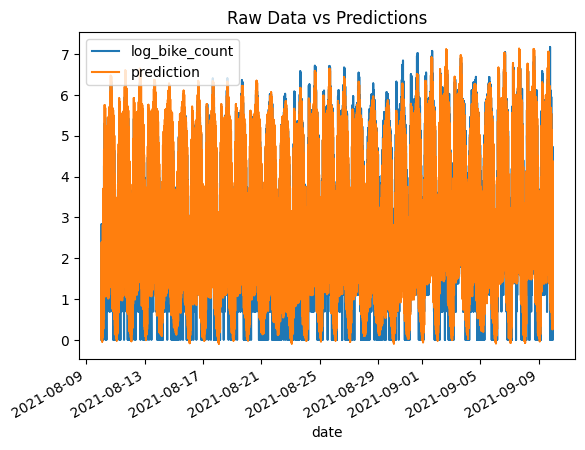

In [54]:
ax = combined_test[["log_bike_count"]].plot()
combined_test["prediction"].plot(ax=ax)
plt.legend()
ax.set_title("Raw Data vs Predictions")
plt.show()

In [58]:
combined_test.index.min()

Timestamp('2021-08-10 01:00:00')

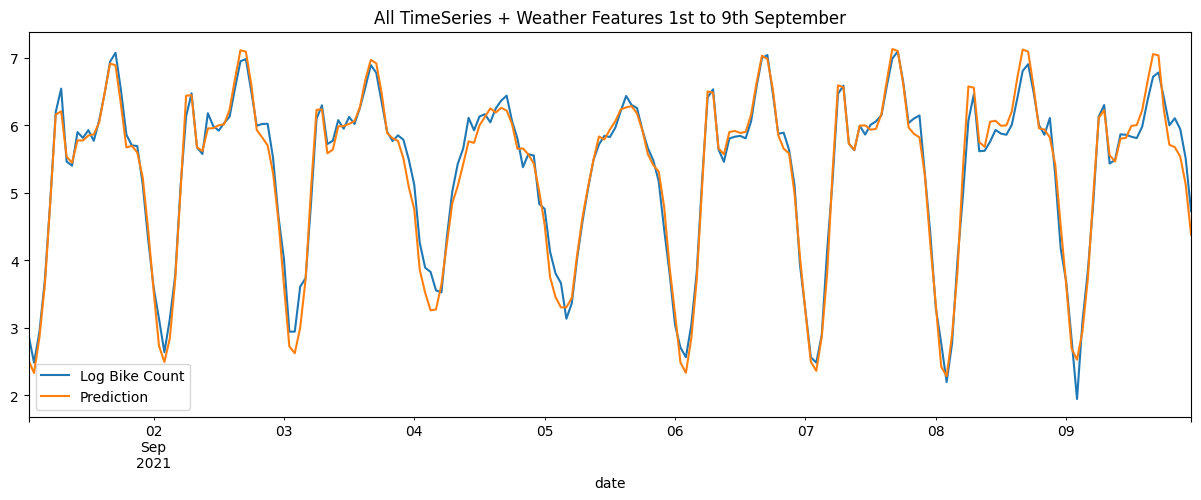

In [63]:
# Filter the dataframe for the given counter name and date range
filtered_data = combined_test[
    (combined_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (combined_test.index > "2021-09-01")
    & (combined_test.index < "2021-09-10")
]

# Plot the log_bike_count
filtered_data["log_bike_count"].plot(figsize=(15, 5), label="Log Bike Count")

# Plot the prediction
filtered_data["prediction"].plot(figsize=(15, 5), label="Prediction")

# Add legend to differentiate the plots
plt.legend()
plt.title("All TimeSeries + Weather Features 1st to 9th September")
# Show the plot
plt.show()

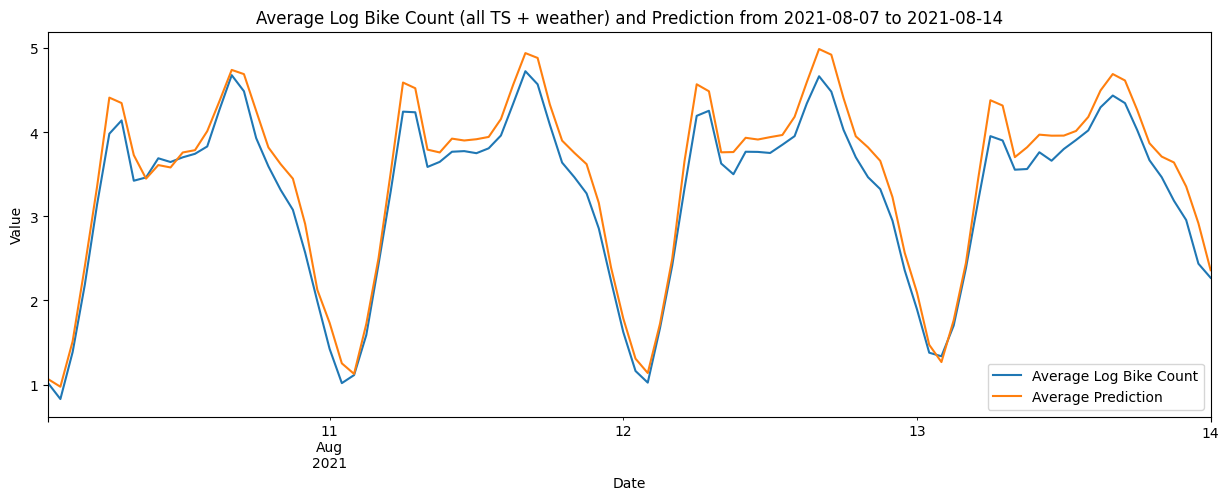

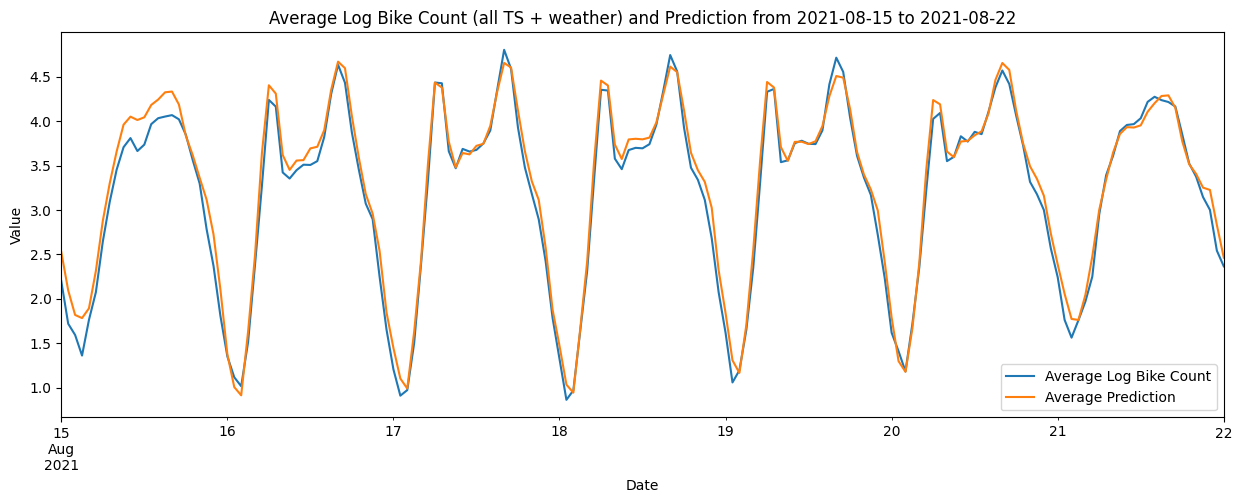

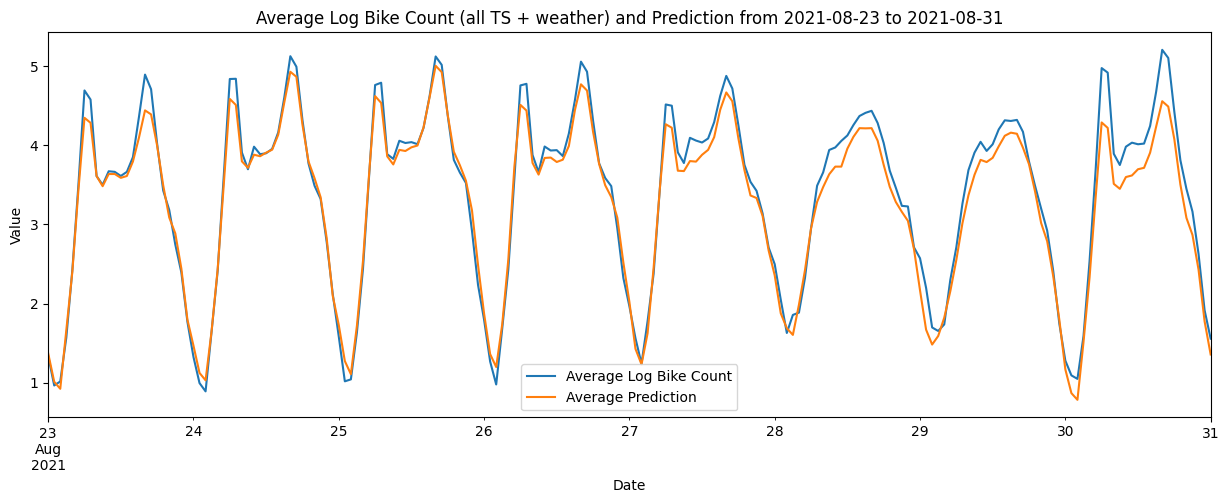

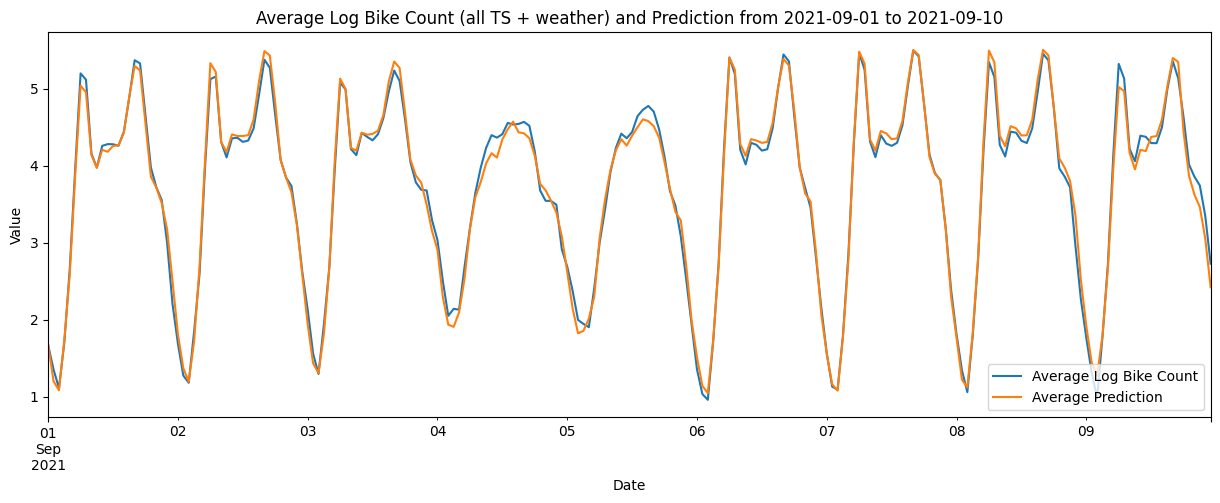

In [66]:
date_ranges = [
    ("2021-08-07", "2021-08-14"),
    ("2021-08-15", "2021-08-22"),
    ("2021-08-23", "2021-08-31"),
    ("2021-09-01", "2021-09-10"),
]

# Loop over each date range and create separate plots
for i, (start_date, end_date) in enumerate(date_ranges, start=1):
    # Filter the data for the given date range
    date_filtered_data = combined_test[
        (combined_test.index >= start_date) & (combined_test.index <= end_date)
    ]

    # Select only the numeric columns for averaging
    numeric_cols = date_filtered_data.select_dtypes(include=[np.number])

    # Group by the index (date) and calculate the mean for each numeric column
    average_data = numeric_cols.groupby(numeric_cols.index).mean()

    # Set up the figure for plotting
    plt.figure(figsize=(15, 5))

    # Plot the average log_bike_count
    average_data["log_bike_count"].plot(label="Average Log Bike Count")

    # Plot the average prediction
    average_data["prediction"].plot(label="Average Prediction")

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel("Value")
    title = f"Average Log Bike Count (all TS + weather) and Prediction from {start_date} to {end_date}"
    plt.title(title)

    # Add legend to differentiate the plots
    plt.legend()

    # Filename: remove non-alphanumeric characters, replace spaces with underscores
    filename = re.sub(r"\W+", "", title.replace(" ", "_")) + ".png"

    # Save the figure
    plt.savefig(filename)

    # Show the plot
    plt.show()

In [108]:
def objective(trial):
    # Define the hyperparameters to search over
    params = {
        "iterations": trial.suggest_int(
            "iterations", 100, 1000
        ),  # Number of iterations
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.001, 0.1
        ),  # Learning rate
        "depth": trial.suggest_int("depth", 4, 10),  # Depth of the tree
        "l2_leaf_reg": trial.suggest_float(
            "l2_leaf_reg", 1e-5, 100
        ),  # L2 regularization
        "random_strength": trial.suggest_float(
            "random_strength", 0, 1
        ),  # Random strength
        "bagging_temperature": trial.suggest_float(
            "bagging_temperature", 0, 1
        ),  # Bagging temperature
    }

    # Create the CatBoost model
    model = cat.CatBoostRegressor(
        **params, verbose=10, cat_features=cat_feature)

    # Fit the model to the training data
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=10,
    )

    # Calculate the validation RMSE (you can use other metrics as well)
    val_pred = model.predict(X_test)
    val_rmse = np.sqrt(mean_squared_error(y_test, val_pred))

    # Return the validation RMSE as the objective value to minimize
    return val_rmse

In [109]:
study = optuna.create_study(direction="minimize")

[I 2023-12-10 22:14:16,351] A new study created in memory with name: no-name-67df545d-73c3-4bb8-97d9-ae8c8911399b


In [110]:
study.optimize(objective, n_trials=10)

0:	learn: 1.5802455	test: 1.4037767	best: 1.4037767 (0)	total: 230ms	remaining: 37.7s
10:	learn: 1.0787870	test: 0.9795331	best: 0.9795331 (10)	total: 998ms	remaining: 14s
20:	learn: 0.8023502	test: 0.6901341	best: 0.6901341 (20)	total: 1.62s	remaining: 11.1s
30:	learn: 0.7261838	test: 0.6157188	best: 0.6157188 (30)	total: 2.23s	remaining: 9.66s
40:	learn: 0.6966682	test: 0.5893661	best: 0.5893661 (40)	total: 2.85s	remaining: 8.61s
50:	learn: 0.6800956	test: 0.5782165	best: 0.5782165 (50)	total: 3.47s	remaining: 7.75s
60:	learn: 0.6682401	test: 0.5700130	best: 0.5700130 (60)	total: 4.08s	remaining: 6.95s
70:	learn: 0.6590114	test: 0.5607407	best: 0.5607407 (70)	total: 4.68s	remaining: 6.2s
80:	learn: 0.6523921	test: 0.5529502	best: 0.5529502 (80)	total: 5.29s	remaining: 5.48s
90:	learn: 0.6461300	test: 0.5489759	best: 0.5486619 (88)	total: 5.9s	remaining: 4.79s
100:	learn: 0.6420136	test: 0.5427650	best: 0.5427637 (99)	total: 6.5s	remaining: 4.12s
110:	learn: 0.6382057	test: 0.5381022	

[I 2023-12-10 22:14:28,205] Trial 0 finished with value: 0.5269272576867213 and parameters: {'iterations': 165, 'learning_rate': 0.09439256744665762, 'depth': 8, 'l2_leaf_reg': 81.16421667393797, 'random_strength': 0.4280994859006493, 'bagging_temperature': 0.5449245497198891}. Best is trial 0 with value: 0.5269272576867213.


164:	learn: 0.6235238	test: 0.5269273	best: 0.5269273 (164)	total: 10.4s	remaining: 0us

bestTest = 0.526927257
bestIteration = 164

0:	learn: 1.5923922	test: 1.4086507	best: 1.4086507 (0)	total: 74.6ms	remaining: 55.3s
10:	learn: 1.0843761	test: 0.9250459	best: 0.9250459 (10)	total: 609ms	remaining: 40.5s
20:	learn: 0.8916973	test: 0.7561058	best: 0.7561058 (20)	total: 1.13s	remaining: 38.9s
30:	learn: 0.8133993	test: 0.6991208	best: 0.6991208 (30)	total: 1.7s	remaining: 38.9s
40:	learn: 0.7701556	test: 0.6638623	best: 0.6638623 (40)	total: 2.29s	remaining: 39.2s
50:	learn: 0.7464590	test: 0.6416774	best: 0.6416774 (50)	total: 2.88s	remaining: 39.1s
60:	learn: 0.7303738	test: 0.6252763	best: 0.6252763 (60)	total: 3.49s	remaining: 38.9s
70:	learn: 0.7153465	test: 0.6158384	best: 0.6158384 (70)	total: 4.1s	remaining: 38.7s
80:	learn: 0.7046898	test: 0.6081218	best: 0.6081218 (80)	total: 4.71s	remaining: 38.5s
90:	learn: 0.6938701	test: 0.5959198	best: 0.5959198 (90)	total: 5.35s	remaini

[I 2023-12-10 22:15:19,501] Trial 1 finished with value: 0.4589130421866642 and parameters: {'iterations': 742, 'learning_rate': 0.07343853182367419, 'depth': 5, 'l2_leaf_reg': 76.31877800998082, 'random_strength': 0.7041084359182732, 'bagging_temperature': 0.4539232758358517}. Best is trial 1 with value: 0.4589130421866642.


0:	learn: 1.6366604	test: 1.4550879	best: 1.4550879 (0)	total: 67.2ms	remaining: 12.8s
10:	learn: 1.3506610	test: 1.2092052	best: 1.2092052 (10)	total: 655ms	remaining: 10.7s
20:	learn: 1.1902194	test: 1.0818839	best: 1.0818839 (20)	total: 1.24s	remaining: 10s
30:	learn: 1.0244158	test: 0.9174758	best: 0.9174758 (30)	total: 1.83s	remaining: 9.44s
40:	learn: 0.9074399	test: 0.7951326	best: 0.7951326 (40)	total: 2.41s	remaining: 8.82s
50:	learn: 0.8404539	test: 0.7276204	best: 0.7276204 (50)	total: 2.99s	remaining: 8.2s
60:	learn: 0.7995553	test: 0.6852033	best: 0.6852033 (60)	total: 3.56s	remaining: 7.59s
70:	learn: 0.7718819	test: 0.6598459	best: 0.6598459 (70)	total: 4.15s	remaining: 7.01s
80:	learn: 0.7526207	test: 0.6415503	best: 0.6415503 (80)	total: 4.75s	remaining: 6.45s
90:	learn: 0.7392384	test: 0.6284828	best: 0.6284828 (90)	total: 5.32s	remaining: 5.85s
100:	learn: 0.7279828	test: 0.6192005	best: 0.6192005 (100)	total: 5.91s	remaining: 5.27s
110:	learn: 0.7184535	test: 0.6107

[I 2023-12-10 22:15:31,038] Trial 2 finished with value: 0.5812601390650325 and parameters: {'iterations': 191, 'learning_rate': 0.03896944237593699, 'depth': 6, 'l2_leaf_reg': 42.69314499212935, 'random_strength': 0.956025546222303, 'bagging_temperature': 0.4642656759310554}. Best is trial 1 with value: 0.4589130421866642.


190:	learn: 0.6806107	test: 0.5812601	best: 0.5812601 (190)	total: 11.2s	remaining: 0us

bestTest = 0.5812601382
bestIteration = 190

0:	learn: 1.5884603	test: 1.4047071	best: 1.4047071 (0)	total: 98.7ms	remaining: 1m 12s
10:	learn: 1.0685853	test: 0.9129955	best: 0.9129955 (10)	total: 781ms	remaining: 51.3s
20:	learn: 0.8802094	test: 0.7473271	best: 0.7473271 (20)	total: 1.45s	remaining: 49.2s
30:	learn: 0.8039388	test: 0.6892363	best: 0.6892363 (30)	total: 2.18s	remaining: 49.5s
40:	learn: 0.7619505	test: 0.6556158	best: 0.6556158 (40)	total: 2.96s	remaining: 50s
50:	learn: 0.7395786	test: 0.6353257	best: 0.6353257 (50)	total: 3.72s	remaining: 49.8s
60:	learn: 0.7217911	test: 0.6200975	best: 0.6200975 (60)	total: 4.56s	remaining: 50.4s
70:	learn: 0.7084970	test: 0.6113179	best: 0.6113179 (70)	total: 5.42s	remaining: 50.6s
80:	learn: 0.6999781	test: 0.6047690	best: 0.6047690 (80)	total: 6.28s	remaining: 50.6s
90:	learn: 0.6904431	test: 0.5974369	best: 0.5974369 (90)	total: 7.13s	remai

[I 2023-12-10 22:16:31,346] Trial 3 finished with value: 0.45711483277100345 and parameters: {'iterations': 734, 'learning_rate': 0.0767229703518425, 'depth': 5, 'l2_leaf_reg': 26.643033530485667, 'random_strength': 0.5555767834324928, 'bagging_temperature': 0.6554050755600216}. Best is trial 3 with value: 0.45711483277100345.


0:	learn: 1.6645952	test: 1.4776086	best: 1.4776086 (0)	total: 111ms	remaining: 35.2s
10:	learn: 1.5657799	test: 1.3828049	best: 1.3828049 (10)	total: 1.03s	remaining: 28.6s
20:	learn: 1.4770620	test: 1.2981179	best: 1.2981179 (20)	total: 1.93s	remaining: 27.3s
30:	learn: 1.3976212	test: 1.2224775	best: 1.2224775 (30)	total: 2.79s	remaining: 25.7s
40:	learn: 1.3263833	test: 1.1539769	best: 1.1539769 (40)	total: 3.68s	remaining: 24.8s
50:	learn: 1.2625612	test: 1.0924768	best: 1.0924768 (50)	total: 4.58s	remaining: 23.9s
60:	learn: 1.2046119	test: 1.0367083	best: 1.0367083 (60)	total: 5.54s	remaining: 23.3s
70:	learn: 1.1530394	test: 0.9873184	best: 0.9873184 (70)	total: 6.45s	remaining: 22.3s
80:	learn: 1.1073597	test: 0.9443173	best: 0.9443173 (80)	total: 7.42s	remaining: 21.6s
90:	learn: 1.0657642	test: 0.9043611	best: 0.9043611 (90)	total: 8.31s	remaining: 20.7s
100:	learn: 1.0291930	test: 0.8709270	best: 0.8709270 (100)	total: 9.21s	remaining: 19.7s
110:	learn: 0.9962817	test: 0.84

[I 2023-12-10 22:17:02,215] Trial 4 finished with value: 0.6273334247776383 and parameters: {'iterations': 317, 'learning_rate': 0.008684626617892731, 'depth': 7, 'l2_leaf_reg': 11.439924847373302, 'random_strength': 0.6560397070010395, 'bagging_temperature': 0.5251910111136892}. Best is trial 3 with value: 0.45711483277100345.


316:	learn: 0.7387478	test: 0.6273334	best: 0.6273334 (316)	total: 30.4s	remaining: 0us

bestTest = 0.6273334263
bestIteration = 316

0:	learn: 1.6478696	test: 1.4618165	best: 1.4618165 (0)	total: 133ms	remaining: 2m 9s
10:	learn: 1.4135017	test: 1.2378218	best: 1.2378218 (10)	total: 1.26s	remaining: 1m 50s
20:	learn: 1.2376324	test: 1.0693547	best: 1.0693547 (20)	total: 2.35s	remaining: 1m 46s
30:	learn: 1.1043971	test: 0.9428715	best: 0.9428715 (30)	total: 3.44s	remaining: 1m 44s
40:	learn: 1.0039047	test: 0.8497433	best: 0.8497433 (40)	total: 4.54s	remaining: 1m 43s
50:	learn: 0.9288972	test: 0.7821108	best: 0.7821108 (50)	total: 5.64s	remaining: 1m 41s
60:	learn: 0.8713006	test: 0.7290492	best: 0.7290492 (60)	total: 6.79s	remaining: 1m 41s
70:	learn: 0.8291023	test: 0.6926873	best: 0.6926873 (70)	total: 7.95s	remaining: 1m 41s
80:	learn: 0.7973750	test: 0.6665315	best: 0.6665315 (80)	total: 9.1s	remaining: 1m 40s
90:	learn: 0.7732981	test: 0.6451939	best: 0.6451939 (90)	total: 10.3

[I 2023-12-10 22:19:07,400] Trial 5 finished with value: 0.46141822907461727 and parameters: {'iterations': 973, 'learning_rate': 0.02215881765218313, 'depth': 8, 'l2_leaf_reg': 35.36028480880766, 'random_strength': 0.756742579100867, 'bagging_temperature': 0.2720957534987236}. Best is trial 3 with value: 0.45711483277100345.


0:	learn: 1.5758280	test: 1.4010276	best: 1.4010276 (0)	total: 113ms	remaining: 21.3s
10:	learn: 1.0271551	test: 0.9247652	best: 0.9247652 (10)	total: 1.21s	remaining: 19.6s
20:	learn: 0.7650471	test: 0.6532061	best: 0.6532061 (20)	total: 2.27s	remaining: 18.2s
30:	learn: 0.6945015	test: 0.5898790	best: 0.5898790 (30)	total: 3.33s	remaining: 17s
40:	learn: 0.6686440	test: 0.5687596	best: 0.5687596 (40)	total: 4.39s	remaining: 15.9s
50:	learn: 0.6531157	test: 0.5572001	best: 0.5572001 (50)	total: 5.44s	remaining: 14.7s
60:	learn: 0.6440676	test: 0.5476819	best: 0.5476819 (60)	total: 6.48s	remaining: 13.6s
70:	learn: 0.6368789	test: 0.5443325	best: 0.5441033 (69)	total: 7.52s	remaining: 12.5s
80:	learn: 0.6310251	test: 0.5392803	best: 0.5392803 (80)	total: 8.57s	remaining: 11.4s
90:	learn: 0.6265277	test: 0.5322939	best: 0.5322939 (90)	total: 9.62s	remaining: 10.4s
100:	learn: 0.6228839	test: 0.5278745	best: 0.5278745 (100)	total: 10.7s	remaining: 9.3s
110:	learn: 0.6202859	test: 0.52274

[I 2023-12-10 22:19:27,788] Trial 6 finished with value: 0.5108173624393574 and parameters: {'iterations': 189, 'learning_rate': 0.09804375251795373, 'depth': 10, 'l2_leaf_reg': 90.63142675095345, 'random_strength': 0.2903490140278303, 'bagging_temperature': 0.5494225858882874}. Best is trial 3 with value: 0.45711483277100345.


188:	learn: 0.6054894	test: 0.5108310	best: 0.5108174 (186)	total: 20s	remaining: 0us

bestTest = 0.5108173623
bestIteration = 186

Shrink model to first 187 iterations.
0:	learn: 1.6342366	test: 1.4486455	best: 1.4486455 (0)	total: 110ms	remaining: 1m 15s
10:	learn: 1.3154813	test: 1.1411406	best: 1.1411406 (10)	total: 718ms	remaining: 43.9s
20:	learn: 1.1111603	test: 0.9515337	best: 0.9515337 (20)	total: 1.39s	remaining: 44s
30:	learn: 0.9835342	test: 0.8378625	best: 0.8378625 (30)	total: 2.05s	remaining: 43.1s
40:	learn: 0.9040394	test: 0.7681834	best: 0.7681834 (40)	total: 2.72s	remaining: 42.6s
50:	learn: 0.8537292	test: 0.7284558	best: 0.7284558 (50)	total: 3.41s	remaining: 42.3s
60:	learn: 0.8187132	test: 0.7014002	best: 0.7014002 (60)	total: 4.15s	remaining: 42.4s
70:	learn: 0.7933463	test: 0.6814811	best: 0.6814811 (70)	total: 4.91s	remaining: 42.4s
80:	learn: 0.7738572	test: 0.6670663	best: 0.6670663 (80)	total: 5.71s	remaining: 42.5s
90:	learn: 0.7585540	test: 0.6543894	best

[I 2023-12-10 22:19:50,286] Trial 7 finished with value: 0.5724611081867986 and parameters: {'iterations': 684, 'learning_rate': 0.036069268264529455, 'depth': 5, 'l2_leaf_reg': 48.733621453768336, 'random_strength': 0.9097331954644571, 'bagging_temperature': 0.002866613903413362}. Best is trial 3 with value: 0.45711483277100345.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.5724611071
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 1.6443711	test: 1.4592820	best: 1.4592820 (0)	total: 94ms	remaining: 1m 19s
10:	learn: 1.3894776	test: 1.2151263	best: 1.2151263 (10)	total: 640ms	remaining: 48.7s
20:	learn: 1.2120730	test: 1.0511761	best: 1.0511761 (20)	total: 1.21s	remaining: 47.6s
30:	learn: 1.0875305	test: 0.9417053	best: 0.9417053 (30)	total: 1.73s	remaining: 45.6s
40:	learn: 1.0003012	test: 0.8661876	best: 0.8661876 (40)	total: 2.28s	remaining: 44.8s
50:	learn: 0.9396088	test: 0.8137262	best: 0.8137262 (50)	total: 2.81s	remaining: 43.9s
60:	learn: 0.8963686	test: 0.7760331	best: 0.7760331 (60)	total: 3.33s	remaining: 42.9s
70:	learn: 0.8650668	test: 0.7489940	best: 0.7489940 (70)	total: 3.9s	remaining: 42.7s
80:	learn: 0.8396475	test: 0.7300530	best: 0.7300530 (80)	total: 4.53s	remaining: 42.9s
90:	learn: 0.8199233	test: 0.7148840	best: 0.7148840 (90)	total: 5.1s	rem

[I 2023-12-10 22:20:41,570] Trial 8 finished with value: 0.5341666741216935 and parameters: {'iterations': 848, 'learning_rate': 0.028541900663317573, 'depth': 4, 'l2_leaf_reg': 57.867517704486694, 'random_strength': 0.7526239722579084, 'bagging_temperature': 0.45483490582198927}. Best is trial 3 with value: 0.45711483277100345.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.534166673
bestIteration = 803

Shrink model to first 804 iterations.
0:	learn: 1.6407478	test: 1.4550145	best: 1.4550145 (0)	total: 126ms	remaining: 43.1s
10:	learn: 1.3563922	test: 1.1817785	best: 1.1817785 (10)	total: 1.24s	remaining: 37.6s
20:	learn: 1.1583489	test: 0.9933720	best: 0.9933720 (20)	total: 2.38s	remaining: 36.6s
30:	learn: 1.0195987	test: 0.8638049	best: 0.8638049 (30)	total: 3.47s	remaining: 35s
40:	learn: 0.9225834	test: 0.7761246	best: 0.7761246 (40)	total: 4.59s	remaining: 33.9s
50:	learn: 0.8554015	test: 0.7164853	best: 0.7164853 (50)	total: 5.72s	remaining: 32.9s
60:	learn: 0.8091263	test: 0.6787569	best: 0.6787569 (60)	total: 6.93s	remaining: 32.2s
70:	learn: 0.7754792	test: 0.6512159	best: 0.6512159 (70)	total: 8.13s	remaining: 31.2s
80:	learn: 0.7519492	test: 0.6337715	best: 0.6337715 (80)	total: 9.34s	remaining: 30.3s
90:	learn: 0.7354304	test: 0.6217407	best: 0.6217407 (90)	total: 10.5s	rema

[I 2023-12-10 22:21:24,060] Trial 9 finished with value: 0.5154128476308684 and parameters: {'iterations': 344, 'learning_rate': 0.027872143031210172, 'depth': 8, 'l2_leaf_reg': 17.961836542483496, 'random_strength': 0.675856762509769, 'bagging_temperature': 0.7298084275195226}. Best is trial 3 with value: 0.45711483277100345.


343:	learn: 0.5588292	test: 0.5154128	best: 0.5154128 (343)	total: 41.9s	remaining: 0us

bestTest = 0.5154128466
bestIteration = 343



In [111]:
best_params_catboost = study.best_params

In [166]:
best_params_catboost = {
    "iterations": 734,
    "learning_rate": 0.0767229703518425,
    "depth": 5,
    "l2_leaf_reg": 26.643033530485667,
    "random_strength": 0.5555767834324928,
    "bagging_temperature": 0.6554050755600216,
}

In [167]:
final_catboost_model = cat.CatBoostRegressor(
    **best_params_catboost,
    verbose=10,
)

In [168]:
final_catboost_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    cat_features=cat_feature,
)

0:	learn: 1.5884603	test: 1.4047071	best: 1.4047071 (0)	total: 102ms	remaining: 1m 14s
10:	learn: 1.0685853	test: 0.9129955	best: 0.9129955 (10)	total: 907ms	remaining: 59.6s
20:	learn: 0.8802094	test: 0.7473271	best: 0.7473271 (20)	total: 1.59s	remaining: 54.1s
30:	learn: 0.8039388	test: 0.6892363	best: 0.6892363 (30)	total: 2.34s	remaining: 53.1s
40:	learn: 0.7619505	test: 0.6556158	best: 0.6556158 (40)	total: 3.09s	remaining: 52.2s
50:	learn: 0.7395786	test: 0.6353257	best: 0.6353257 (50)	total: 3.81s	remaining: 51s
60:	learn: 0.7217911	test: 0.6200975	best: 0.6200975 (60)	total: 4.61s	remaining: 50.8s
70:	learn: 0.7084970	test: 0.6113179	best: 0.6113179 (70)	total: 5.54s	remaining: 51.8s
80:	learn: 0.6999781	test: 0.6047690	best: 0.6047690 (80)	total: 6.4s	remaining: 51.6s
90:	learn: 0.6904431	test: 0.5974369	best: 0.5974369 (90)	total: 7.31s	remaining: 51.7s
100:	learn: 0.6819692	test: 0.5910887	best: 0.5910887 (100)	total: 8.17s	remaining: 51.2s
110:	learn: 0.6694927	test: 0.5792

In [169]:
y_pred = final_catboost_model.predict(X_test)
rmse_cat = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_cat)

0.45711483277100345
